In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from SimPEG import Mesh
from SimPEG import Problem
from SimPEG import Survey
from SimPEG import DataMisfit
from SimPEG import Directives
from SimPEG import Optimization
from SimPEG import Regularization
from SimPEG import InvProblem
from SimPEG import Inversion
from SimPEG import Maps, Utils
from SimPEG.Utils import mkvc

In [2]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm
def getLpNorm(m, p, eps):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """
    phi = np.sum(m**2./(m**2. + eps**2.)**(1.-p/2.))
    return phi

def getLpNormDeriv(m, p, eps):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """
    dmdx = reg.regmesh.cellDiffxStencil * m
    phi = np.sum(dmdx**2./(dmdx**2. + eps**2.)**(1.-p/2.))
    return phi

def getLsNormMaxDeriv(m, p, eps, scaled):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """
    
    
    if scaled:   
        if p<1:
            mmax = eps/np.sqrt(1-p)
        else:
            mmax = np.abs(m).max()
        maxGrad = mmax/(mmax**2. + eps**2.)**(1.-p/2.)
        gamma = np.abs(m).max()/maxGrad
    else:
        gamma = 1
    dphidm = gamma * m / (m**2. + eps**2.)**(1.-p/2.)

    return np.abs(dphidm).max()

def getLxNormMaxDeriv(m, p, eps, scaled):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """

    dmdx = reg.regmesh.cellDiffxStencil * m
    
    if scaled:
        if p<1:
            mmax = eps/np.sqrt(1-p)
        else:
            mmax = np.abs(dmdx).max()
        maxGrad = mmax/(mmax**2. + eps**2.)**(1.-p/2.)
        gamma = np.abs(dmdx).max()/maxGrad
    else:
        gamma = 1
    dphidm = gamma * dmdx/(dmdx**2. + eps**2.)**(1.-p/2.)
    return np.abs(dphidm).max()
def getLsNormDeriv(m, p, eps, scaled):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """
    
    
    if scaled:   
        if p<1:
            mmax = eps/np.sqrt(1-p)
        else:
            mmax = np.abs(m).max()
        maxGrad = mmax/(mmax**2. + eps**2.)**(1.-p/2.)
        gamma = np.abs(m).max()/maxGrad
    else:
        gamma = 1
    dphidm = gamma * m / (m**2. + eps**2.)**(1.-p/2.)

    return dphidm

def getLxNormDeriv(m, p, eps, scaled):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """

    dmdx = reg.regmesh.cellDiffxStencil * m
    
    if scaled:
        if p<1:
            mmax = eps/np.sqrt(1-p)
        else:
            mmax = np.abs(dmdx).max()
        maxGrad = mmax/(mmax**2. + eps**2.)**(1.-p/2.)
        gamma = np.abs(dmdx).max()/maxGrad
    else:
        gamma = 1
    dphidm = gamma * (reg.regmesh.cellDiffxStencil.T * (dmdx/(dmdx**2. + eps**2.)**(1.-p/2.)))
    return dphidm

In [3]:
np.random.seed(1)

dx = 1./50

N = np.ones(50) * dx

std_noise = 0.0005

mesh = Mesh.TensorMesh([N])

m0 = np.ones(mesh.nC) * 1e-4
mref = np.zeros(mesh.nC)

nk = 10
jk = np.linspace(1., nk, nk)
p = 1.0
q = 1.1
winSize = 20
center = np.linspace(0,mesh.nC,nk+2, dtype=int)

np.random.seed(7)

# row = np.zeros(mesh.nC)
# ind = np.random.choice(mesh.nC,int(mesh.nC/nk))
# row[ind] = 1.
# indNext =np.where(row==0)[0]
# indNext.shape
cntr = np.linspace(0,mesh.nC-1,nk).astype('int')
def g(k, indVec):
#     return ((1)**(k)*
#         np.exp(-p*(k+1)*mesh.vectorNx[:-1]*np.pi/mesh.vectorNx[-1]) *
#         np.cos(q*(k)*mesh.vectorNx[:-1]*np.pi/mesh.vectorNx[-1])
#     )
    
#     xmin, xmax = np.max([0,center[k+1]-winSize]), np.min([mesh.vnC[0],center[k+1]+winSize+1])
#     kernel = np.zeros(mesh.nC)
    
#     kernel[xmin:xmax] = 1
    row = np.zeros(mesh.nC)
    
    ii = np.random.choice(indVec.shape[0],int(mesh.nC/nk), replace=False)
    
    row = np.abs(np.random.randn(int(mesh.nC)))
    
#     row *= np.exp(-(((mesh.vectorCCx-mesh.vectorCCx[cntr[k]]))**2. ))
    
    return row
#     return (1)**(k)*np.cos(p*(k+1)*mesh.vectorCCx + np.pi/8)

#     return (
#         np.exp(-p*(k+1)**2.*mesh.vectorNx[:-1]/mesh.vectorNx[-1]))
F = np.zeros((nk, mesh.nC))
for i in range(nk):
    
    indVec = np.asarray(range(mesh.nC))#np.where(F.sum(0)==0)[0]
    F[i, :] = g(i, indVec) * mesh.vol

# Add square anomaly
mtrue = np.zeros(mesh.nC)
mtrue[21:28] = 0.25
# mtrue[30:32] = 0.25
# mtrue[40:45] = 0.25

# Add Gaussian anomaly
# cntr = mesh.vectorCCx[35]
# mtrue += 0.3* np.exp(-(((mesh.vectorCCx-cntr) /5)**2. ))

# mtrue[60] = -0.5
# mtrue[mesh.vectorCCx > 0.6] = 0


# indx = np.random.randint(0,mesh.nC,10)
# mtrue[indx] = np.random.rand(10)

prob = Problem.LinearProblem(mesh, G=F)
survey = Survey.LinearSurvey()
survey.pair(prob)

data = prob.fields(mtrue)
survey.dobs = data + std_noise * np.random.randn(nk)

wd = np.ones(nk) * std_noise

# Distance weighting
wr = np.sum(prob.G**2., axis=0)**0.5
wr = wr/np.max(wr)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=mesh.nC)




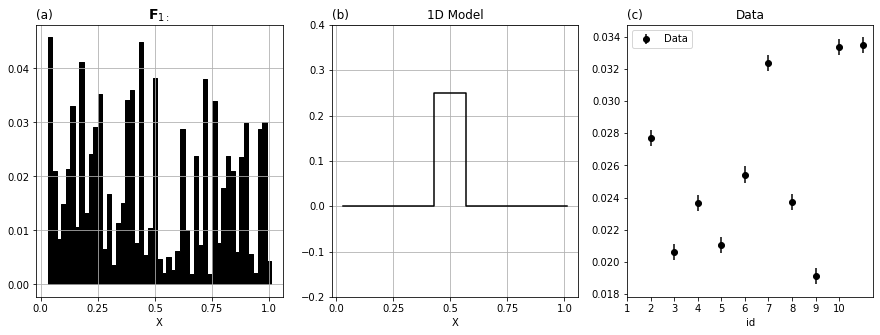

In [4]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,3,1)
for i in range(1):
    ax1.fill_between(mesh.vectorCCx,prob.G[i, :], step="pre", alpha=1.0, color=np.r_[0,0,0]/(i+2))
#     ax1.step(mesh.vectorCCx, prob.F[i, :], color=np.r_[1,1,1]/(i+2), lw=2)
ax1.set_title('$\mathbf{F}_{1:}$', size=14)
ax1.set_title('(a)', loc='left')
ax1.set_xticks(np.linspace(-1,49,5)/50)
ax1.set_xticklabels(np.linspace(0,1,5))
ax1.set_xlabel("X")
ax1.grid('on')

ax2 = plt.subplot(1,3,2)
ax2.step(mesh.vectorCCx, mtrue, 'k-')
ax2.set_title('(b)', loc='left')
ax2.grid('on')
ax2.set_xlabel("X")
ax2.set_xticks(np.linspace(-1,49,5)/50)
ax2.set_xticklabels(np.linspace(0,1,5))
ax2.set_title('1D Model')
ax2.set_ylim(-.2, 0.4)

ax3 = plt.subplot(1,3,3)
ax3.errorbar(np.asarray(range(10))+1,data,yerr=wd,linestyle=' ', color='k', marker='o')
# ax3.plot(survey.dobs,'k--')
ax3.set_title('Data')
ax3.set_title('(c)', loc='left')
ax3.set_xlabel("id")
ax3.set_xticks(range(0,nk))
ax3.set_xticklabels(range(1,nk+1))
ax3.legend(['Data', 'Data+noise'])
plt.show()

fig.savefig('Problem1D_KernelModel.png',bbox_inches='tight')

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Optimization terminated successfully.


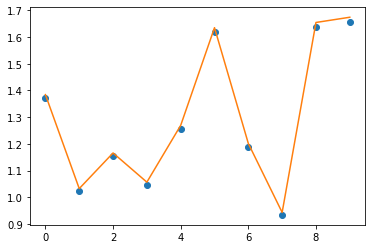

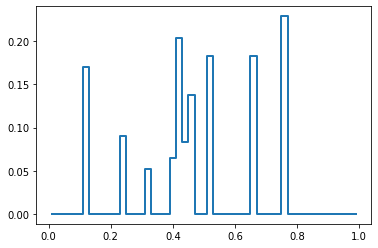

17.2738031306846 10


In [5]:
# Solve the linear programming problem
import scipy.optimize as spOpt

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./wd

mLP = spOpt.linprog(np.ones(mesh.nC), A_eq=F, b_eq = survey.dobs/(1.+std_noise))

print(mLP.message)
    
dpre = np.sum(((survey.dobs - np.dot(F,mLP.x)) / wd)**2.)

plt.figure()
plt.plot(np.dot(F,mLP.x),'o')
plt.plot(survey.dobs)

plt.figure()
plt.step(mesh.vectorCCx, mLP.x, lw=2)
plt.show()

print(dpre, np.sum(mLP.x>1e-4))

In [6]:
# # Define a small function that takes a model, p and epsilon values and return the value of the norm
# regTikh = Regularization.Tikhonov(mesh, mapping=idenMap)
# def getLpNorm(m, alpha, p, eps):
#     """
#     Compute the approximated lp-norm of m, for given p and epsilon value
    
#     returns phi
#     """
#     reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components')
#     reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
#     reg.mref = np.zeros(mesh.nC)
#     reg.cell_weights = mesh.vol
#     reg.norms = np.c_[p, p]
#     reg.eps_p = eps
#     reg.eps_q = eps
#     reg.alpha_x = alpha
#     reg.alpha_s = alpha
    
# #     phi = np.sum(m**2./(m**2. + eps**2.)**(1.-p/2.))
#     return reg.objfcts[0](m)

# def getLpNormDeriv(m, alpha, p, eps, dx):
#     """
#     Compute the approximated lp-norm of m, for given p and epsilon value
    
#     returns phi
#     """
#     reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components')
#     reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
#     reg.mref = np.zeros(mesh.nC)
#     reg.cell_weights = mesh.vol
#     reg.norms = np.c_[p, p]
#     reg.eps_p = eps
#     reg.eps_q = eps
#     reg.alpha_x = alpha
#     reg.alpha_s = alpha
#     return reg.objfcts[1](m)

# def getLsNormMaxDeriv(m, alpha, p, eps, scaled, dx):
#     """
#     Compute the approximated lp-norm of m, for given p and epsilon value
    
#     returns phi
#     """
#     reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components',scaledIRLS=False)
#     reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
#     reg.mref = np.zeros(mesh.nC)
#     reg.scaledIRLS = False
# #     reg.cell_weights = mesh.vol
#     reg.norms = np.c_[p, p]
# #     reg.scales = np.c_[dx,  1./dx]
#     reg.eps_p = eps
#     reg.eps_q = eps
#     reg.alpha_x = alpha
#     reg.alpha_s = 1./dx**p
# #     print(p,alpha*np.abs(reg.objfcts[0].deriv(m)).max())
#     return alpha*np.abs(reg.objfcts[0].deriv(m)).max()

# def getLxNormMaxDeriv(m, alpha, p, eps, scaled, dx):
#     """
#     Compute the approximated lp-norm of m, for given p and epsilon value
    
#     returns phi
#     """
#     reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components',scaledIRLS=False)
#     reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
#     reg.mref = np.zeros(mesh.nC)
#     reg.scaledIRLS = False
# #     reg.cell_weights = mesh.vol
#     reg.norms = np.c_[p, p]
# #     reg.scales = np.c_[dx,  1./dx]
#     reg.eps_p = eps
#     reg.eps_q = eps
#     reg.alpha_x = alpha
#     reg.alpha_s = 1./dx**p
# #     print(p,alpha*np.abs(reg.objfcts[1].deriv(m)).max())
#     return alpha*np.abs(reg.objfcts[1].deriv(m)).max()

# Run all the combinations of norms

In [6]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm
eps_p = []
eps_q = []
lp = []
lq = []
phi_s = []
phi_x = []
phi_d = []

def invSetter(count, p_s, p_x, a_s, a_x, eps_p, eps_q, coolFact, bounds):
       
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd
    
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)

#     reg.scales = np.c_[dx,  1./dx]
    
    if (count < 3) or count==5:
        reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components', scaledIRLS=False)
        regTikh = Regularization.Tikhonov(mesh, mapping=idenMap)
        reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
        reg.mref = mref
    #     reg.cell_weights = mesh.vol
    #     reg.cell_weights = wr
        reg.norms = np.c_[p_s, p_x]
        reg.eps_p = eps_p
        reg.eps_q = eps_q/dx
        reg.alpha_x = a_x
        reg.alpha_s = 2*a_s/dx**2
        beta = 5e+3
    else:   
        reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components', scaledIRLS=False)
   
        reg.mref = mref
    #     reg.cell_weights = mesh.vol
    #     reg.cell_weights = wr
        reg.norms = np.c_[p_s, p_x]
        reg.eps_p = eps_p
        reg.eps_q = eps_q
        reg.alpha_x = a_x
        reg.alpha_s = a_s*2.
        beta = 5e+3*800.

    print(p_s, p_x, reg.alpha_s, reg.alpha_x)
    opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=bounds[0], upper=bounds[1],
        maxIterLS=20, maxIterCG=100, tolCG=1e-6,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta)
    update_Jacobi = Directives.UpdatePreconditioner()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms
    
    saveDict = Directives.SaveOutputDictEveryIteration()
    
    IRLS = Directives.Update_IRLS(maxIRLSiter=100, minGNiter=1,
                                  coolEpsFact=coolFact, f_min_change = 1e-5, beta_tol = 5e-1,
                                 chifact_start=1.,chifact_target=1., coolEps_p=True, coolEps_q=True,
                                 floorEps_p = 1e-6, floorEps_q = 1e-6, )

    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(np.ones(mesh.nC)*1e-4)
    return mrec, invProb, dmis, saveDict.outDict, reg


p_s = mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist() + [1]
p_x = mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist() + [1]
alpha_x = np.r_[0, 1, 1].tolist()*3 + [1]
alpha_s = np.r_[1., 0, 1.].tolist()*3 + [1.]
coolFact = 1.125

# p_s = [2,1,0]
# p_x = [2,1,0]
# alpha_x = [1,1,1]
# alpha_s = [1,1,1]
# coolFact = 1.15

eps_p0,eps_q0 = 1e-1, 1e-1
models = []
dpred = []
iterations = []
reg_eps = []
betas = []
regAll = []
phi_s_Deriv = []
phi_x_Deriv = []
phi_d_Deriv = []
scaledIRLS = False
for jj, (p, q, a_s, a_x) in enumerate(zip(p_s, p_x, alpha_s, alpha_x)):

#     if jj == 3:
#         p = 0.95
#         bounds = [0, np.inf]
#     else:
#         bounds = [- np.inf,  np.inf]    
#     a_s *= dx**(2-p)
    
#     if jj ==9:
#         a_s *= dx**-1
        
    mm, invProb, dmis, outDict, reg = invSetter(jj, p, q, a_s, a_x, eps_p0, eps_q0, coolFact, [- np.inf,  np.inf])
    print(len(outDict.keys()))
    models += [mm]
    dpred += [invProb.dpred]
    regAll += [reg]
#     iterations += [[iterate]]
    eps_p.append([outDict[ii+1]['eps_p'] for ii in range(invProb.opt.iter)])
    eps_q.append([outDict[ii+1]['eps_q'] for ii in range(invProb.opt.iter)])
    lp.append([outDict[ii+1]['lps'] for ii in range(invProb.opt.iter)])
    lq.append([outDict[ii+1]['lpx'] for ii in range(invProb.opt.iter)])
    phi_s.append([np.abs(outDict[ii+1]['phi_ms']).max() for ii in range(invProb.opt.iter)])
    phi_x.append([np.abs(outDict[ii+1]['phi_msx']).max() for ii in range(invProb.opt.iter)])
    phi_d.append([outDict[ii+1]['phi_d'] for ii in range(invProb.opt.iter)])
    betas.append([outDict[ii+1]['beta'] for ii in range(invProb.opt.iter)])
    reg_eps.append([reg.eps_p, reg.eps_q])
    phi_s_Deriv.append([np.abs(outDict[ii+1]['dphisdm']).max() for ii in range(invProb.opt.iter)])
    phi_x_Deriv.append([np.abs(outDict[ii+1]['dphixdm']).max() for ii in range(invProb.opt.iter)])
    phi_d_Deriv.append([np.abs(dmis.deriv(outDict[ii+1]['m'])).max() for ii in range(invProb.opt.iter)])



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
2.0 2.0 5000.0 0.0
Approximated diag(JtJ) with linear operator
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-05-30-06-36.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+03  8.76e+04  1.25e-03  8.76e+04    7.48e+05      0              
Start CG solve
CG solve time: 0.045000553131103516
   1  2.50e+03  6.87e+04  1.81e+00  7.32e+04    3.37e+05      0              
Start CG solve
CG solve time: 0.046000003814697266
   2  1.25e+03  5.53e+04  5.75e+00  6.25e+04    3.00e+05      0   Skip BFGS  
Start CG solve
CG solve time: 0.058016061782836914
   3  6.25e+02  3.85e+04  1.55e+01  4.82e+04    2.46e+05      0   Skip BFGS 

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:923: RuntimeWarning: invalid value encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


CG solve time: 0.3207569122314453
Beta search step
  14  6.10e-01  3.19e+00  2.77e+02  1.72e+02    9.75e-07      0   Skip BFGS  
Start CG solve
CG solve time: 0.0
delta phim: 6.421e-02
  15  6.10e-01  3.19e+00  2.77e+02  1.72e+02    9.75e-07      0   Skip BFGS  
Start CG solve
CG solve time: 0.0
delta phim: 0.000e+00
Minimum decrease in regularization.End of IRLS
------------------------- STOP! -------------------------
0 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = -8.7589e+04
0 : |xc-x_last| = 0.0000e+00 <= tolX*(1+|x0|) = -1.0007e+00
0 : |proj(x-g)-x|    = 9.7496e-07 <= tolG          = -1.0000e+00
0 : |proj(x-g)-x|    = 9.7496e-07 <= 1e3*eps       = -1.0000e+03
0 : maxIter   =     100    <= iter          =     16
------------------------- DONE! -------------------------
16
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
2.0 2.0 0.0 1.0
Approximated diag(JtJ) with linear operator
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictiona

   0  4.00e+06  8.76e+04  5.00e-07  8.76e+04    7.60e+05      0              
Start CG solve
CG solve time: 0.05699419975280762
   1  2.00e+06  4.47e+04  4.46e-03  5.36e+04    2.67e+05      0              
Start CG solve
CG solve time: 0.0540003776550293
   2  1.00e+06  2.78e+04  1.05e-02  3.83e+04    2.05e+05      0   Skip BFGS  
Start CG solve
CG solve time: 0.06799530982971191
   3  5.00e+05  1.48e+04  1.96e-02  2.46e+04    1.40e+05      0   Skip BFGS  
Start CG solve
CG solve time: 0.07589101791381836
   4  2.50e+05  7.40e+03  2.99e-02  1.49e+04    8.65e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.10299944877624512
   5  1.25e+05  3.86e+03  3.97e-02  8.82e+03    4.98e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.13100147247314453
   6  6.25e+04  2.08e+03  4.96e-02  5.18e+03    2.78e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.15700101852416992
   7  3.12e+04  1.06e+03  6.10e-02  2.97e+03    1.54e+04      0   Skip BFGS  
Start CG solve
CG solve tim

CG solve time: 0.2631356716156006
delta phim: 3.429e-04
  54  2.06e+02  3.89e+00  1.39e+00  2.91e+02    1.88e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.26800036430358887
delta phim: 2.367e-04
  55  2.06e+02  3.96e+00  1.39e+00  2.91e+02    1.88e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.274996280670166
delta phim: 1.445e-04
  56  2.06e+02  4.03e+00  1.39e+00  2.91e+02    1.88e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.25499892234802246
delta phim: 6.425e-05
  57  2.06e+02  4.09e+00  1.39e+00  2.91e+02    1.88e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.24400043487548828
delta phim: 4.904e-06
Minimum decrease in regularization.End of IRLS
------------------------- STOP! -------------------------
0 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = -8.7584e+04
0 : |xc-x_last| = 2.6039e-03 <= tolX*(1+|x0|) = -1.0007e+00
0 : |proj(x-g)-x|    = 1.8777e+02 <= tolG          = -1.0000e+00
0 : |proj(x-g)-x|    = 1.8777e+02 <= 1e3*eps       = -1.00

CG solve time: 0.45191144943237305
delta phim: 2.235e-03
  38  3.91e+02  6.68e+00  2.03e-01  8.62e+01    1.40e+02      0              
Start CG solve
CG solve time: 0.4639582633972168
delta phim: 2.185e-03
  39  3.91e+02  6.67e+00  2.04e-01  8.64e+01    1.44e+02      0              
Start CG solve
CG solve time: 0.45542120933532715
delta phim: 2.102e-03
  40  3.91e+02  6.65e+00  2.04e-01  8.66e+01    1.48e+02      0              
Start CG solve
CG solve time: 0.4526944160461426
delta phim: 1.995e-03
  41  3.91e+02  6.63e+00  2.05e-01  8.67e+01    1.52e+02      0              
Start CG solve
CG solve time: 0.4579288959503174
delta phim: 1.875e-03
  42  3.91e+02  6.61e+00  2.05e-01  8.67e+01    1.55e+02      0              
Start CG solve
CG solve time: 0.43799257278442383
delta phim: 1.744e-03
  43  3.91e+02  6.59e+00  2.05e-01  8.67e+01    1.57e+02      0              
Start CG solve
CG solve time: 0.4328787326812744
delta phim: 1.602e-03
  44  3.91e+02  6.56e+00  2.05e-01  8.67e+01   

CG solve time: 0.6120719909667969
delta phim: 1.855e-04
  93  3.91e+02  6.47e+00  2.03e-01  8.58e+01    1.36e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.6176466941833496
delta phim: 1.812e-04
  94  3.91e+02  6.48e+00  2.03e-01  8.58e+01    1.36e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.7268753051757812
delta phim: 1.769e-04
  95  3.91e+02  6.49e+00  2.03e-01  8.58e+01    1.36e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.6710026264190674
delta phim: 1.726e-04
  96  3.91e+02  6.50e+00  2.03e-01  8.58e+01    1.36e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.652766227722168
delta phim: 1.684e-04
  97  3.91e+02  6.51e+00  2.03e-01  8.58e+01    1.36e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.6569972038269043
delta phim: 1.642e-04
  98  3.91e+02  6.52e+00  2.03e-01  8.58e+01    1.36e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.6575899124145508
delta phim: 1.600e-04
  99  3.91e+02  6.53e+00  2.03e-01  8.58e+01    1.3

CG solve time: 0.7169973850250244
delta phim: 8.957e-03
  41  8.58e-02  4.01e+00  3.58e+03  3.11e+02    1.80e+02      0              
Start CG solve
CG solve time: 0.7029976844787598
delta phim: 7.873e-03
  42  8.58e-02  3.93e+00  3.58e+03  3.11e+02    1.85e+02      0              
Start CG solve
CG solve time: 0.5209975242614746
delta phim: 6.839e-03
  43  8.58e-02  3.87e+00  3.58e+03  3.11e+02    1.88e+02      0              
Start CG solve
CG solve time: 0.5129990577697754
delta phim: 5.870e-03
  44  8.58e-02  3.83e+00  3.58e+03  3.11e+02    1.92e+02      0              
Start CG solve
CG solve time: 0.47969508171081543
delta phim: 4.979e-03
  45  8.58e-02  3.80e+00  3.58e+03  3.11e+02    1.95e+02      0              
Start CG solve
CG solve time: 0.5240013599395752
delta phim: 4.173e-03
  46  8.58e-02  3.79e+00  3.57e+03  3.10e+02    1.98e+02      0              
Start CG solve
CG solve time: 0.4479973316192627
delta phim: 3.459e-03
  47  8.58e-02  3.79e+00  3.57e+03  3.10e+02    2

Start CG solve
CG solve time: 0.21304035186767578
delta phim: 4.830e-04
  96  8.58e-02  4.89e+00  3.53e+03  3.08e+02    1.96e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.23509669303894043
delta phim: 4.788e-04
  97  8.58e-02  4.89e+00  3.53e+03  3.08e+02    1.96e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.2070775032043457
delta phim: 4.746e-04
  98  8.58e-02  4.89e+00  3.53e+03  3.08e+02    1.96e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.23200058937072754
delta phim: 4.704e-04
  99  8.58e-02  4.90e+00  3.53e+03  3.08e+02    1.96e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.2194068431854248
delta phim: 4.661e-04
 100  8.58e-02  4.90e+00  3.53e+03  3.08e+02    1.96e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
0 : |fc-fOld| = 5.1142e-03 <= tolF*(1+|f0|) = -8.7589e+04
0 : |xc-x_last| = 1.2963e-03 <= tolX*(1+|x0|) = -1.0007e+00
0 : |proj(x-g)-x|    = 1.9564e+02 <= tolG          = -1.0000e+00
0 : |proj(x

CG solve time: 0.27378201484680176
Beta search step
  30  4.89e+00  6.19e+00  1.14e+01  6.19e+01    3.96e+02      0              
Start CG solve
CG solve time: 0.29500389099121094
delta phim: 4.487e-02
  31  4.89e+00  5.27e+00  1.13e+01  6.06e+01    4.42e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.2690012454986572
delta phim: 2.257e-02
  32  4.89e+00  5.95e+00  1.10e+01  5.98e+01    3.76e+02      0              
Start CG solve
CG solve time: 0.26599979400634766
delta phim: 1.060e-02
  33  4.89e+00  6.31e+00  1.08e+01  5.91e+01    4.18e+02      0              
Start CG solve
CG solve time: 0.24597787857055664
delta phim: 9.082e-03
  34  4.89e+00  6.31e+00  1.04e+01  5.71e+01    4.95e+02      0              
Start CG solve
CG solve time: 0.23801136016845703
delta phim: 2.948e-02
  35  4.89e+00  6.11e+00  9.84e+00  5.43e+01    5.65e+02      0              
Start CG solve
CG solve time: 0.23009371757507324
delta phim: 4.888e-02
  36  4.89e+00  5.81e+00  9.29e+00  5.13e+01    5

  70  1.24e+00  2.58e+00  8.00e+00  1.25e+01    2.96e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.10082459449768066
Beta search step
  70  2.48e+00  2.58e+00  8.00e+00  2.24e+01    1.57e+03      0   Skip BFGS  
Start CG solve
CG solve time: 0.09882664680480957
delta phim: 2.305e-04
  71  2.48e+00  3.17e+00  8.00e+00  2.30e+01    3.31e+02      0              
Start CG solve
CG solve time: 0.09099912643432617
delta phim: 2.478e-04
  72  2.48e+00  3.63e+00  8.00e+00  2.35e+01    3.55e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.09599184989929199
delta phim: 5.944e-06
Minimum decrease in regularization.End of IRLS
------------------------- STOP! -------------------------
0 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = -8.7584e+04
0 : |xc-x_last| = 1.7993e-03 <= tolX*(1+|x0|) = -1.0007e+00
0 : |proj(x-g)-x|    = 3.5506e+02 <= tolG          = -1.0000e+00
0 : |proj(x-g)-x|    = 3.5506e+02 <= 1e3*eps       = -1.0000e+03
0 : maxIter   =     100    <= iter          =     73

CG solve time: 0.46192216873168945
delta phim: 5.039e-02
  27  1.65e+01  7.12e+00  4.37e+00  7.93e+01    4.01e+02      0              
Start CG solve
CG solve time: 0.450286865234375
Beta search step
  27  1.24e+01  7.12e+00  4.37e+00  6.13e+01    3.57e+02      0              
Start CG solve
CG solve time: 0.45611095428466797
delta phim: 4.290e-02
  28  1.24e+01  5.00e+00  4.54e+00  6.12e+01    4.33e+02      0              
Start CG solve
CG solve time: 0.44336700439453125
delta phim: 3.855e-02
  29  1.24e+01  4.67e+00  4.44e+00  5.96e+01    5.80e+02      0              
Start CG solve
CG solve time: 0.45021867752075195
delta phim: 2.289e-02
  30  1.24e+01  4.35e+00  4.11e+00  5.52e+01    8.34e+02      0              
Start CG solve
CG solve time: 0.47049736976623535
delta phim: 3.331e-02
  31  1.24e+01  4.61e+00  3.72e+00  5.07e+01    5.44e+02      0              
Start CG solve
CG solve time: 0.422243595123291
delta phim: 2.008e-02
  32  1.24e+01  5.95e+00  3.65e+00  5.11e+01    5.39

CG solve time: 0.20300006866455078
   1  2.00e+06  4.55e+04  4.39e-03  5.43e+04    2.70e+05      0              
Start CG solve
CG solve time: 0.19699811935424805
   2  1.00e+06  2.86e+04  1.05e-02  3.91e+04    2.08e+05      0   Skip BFGS  
Start CG solve
CG solve time: 0.1866929531097412
   3  5.00e+05  1.54e+04  1.97e-02  2.53e+04    1.43e+05      0   Skip BFGS  
Start CG solve
CG solve time: 0.18600106239318848
   4  2.50e+05  7.90e+03  3.02e-02  1.54e+04    8.87e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.20599961280822754
   5  1.25e+05  4.38e+03  3.99e-02  9.37e+03    5.14e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.19699859619140625
   6  6.25e+04  2.64e+03  4.96e-02  5.74e+03    2.92e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.22176384925842285
   7  3.12e+04  1.54e+03  6.20e-02  3.48e+03    1.69e+04      0   Skip BFGS  
Start CG solve
CG solve time: 0.29199886322021484
   8  1.56e+04  8.01e+02  7.86e-02  2.03e+03    9.81e+03      0   Skip

CG solve time: 0.25400400161743164
delta phim: 2.760e-04
  44  2.32e+01  6.17e+00  8.01e+00  1.92e+02    3.83e+02      0              
Start CG solve
CG solve time: 0.22520709037780762
delta phim: 2.248e-04
  45  2.32e+01  6.18e+00  8.00e+00  1.92e+02    3.84e+02      0              
Start CG solve
CG solve time: 0.22800087928771973
delta phim: 1.821e-04
  46  2.32e+01  6.19e+00  8.00e+00  1.92e+02    3.85e+02      0              
Start CG solve
CG solve time: 0.21399641036987305
delta phim: 1.468e-04
  47  2.32e+01  6.20e+00  8.00e+00  1.92e+02    3.86e+02      0              
Start CG solve
CG solve time: 0.22144150733947754
delta phim: 1.179e-04
  48  2.32e+01  6.20e+00  8.00e+00  1.92e+02    3.86e+02      0              
Start CG solve
CG solve time: 0.2344353199005127
delta phim: 9.440e-05
  49  2.32e+01  6.21e+00  8.00e+00  1.92e+02    3.87e+02      0              
Start CG solve
CG solve time: 0.23000264167785645
delta phim: 7.538e-05
  50  2.32e+01  6.21e+00  8.00e+00  1.92e+02

CG solve time: 0.4876213073730469
delta phim: 3.713e-03
  29  8.69e+01  5.12e+00  2.02e+00  1.81e+02    8.47e+01      0              
Start CG solve
CG solve time: 0.490525484085083
delta phim: 2.498e-03
  30  8.69e+01  5.14e+00  2.03e+00  1.81e+02    8.53e+01      0              
Start CG solve
CG solve time: 0.4752473831176758
delta phim: 1.506e-03
  31  8.69e+01  5.15e+00  2.03e+00  1.82e+02    8.58e+01      0              
Start CG solve
CG solve time: 0.48761510848999023
delta phim: 6.917e-04
  32  8.69e+01  5.15e+00  2.03e+00  1.82e+02    8.60e+01      0              
Start CG solve
CG solve time: 0.4890007972717285
delta phim: 1.449e-05
  33  8.69e+01  5.14e+00  2.04e+00  1.82e+02    8.60e+01      0              
Start CG solve
CG solve time: 0.48508715629577637
delta phim: 5.597e-04
  34  8.69e+01  5.13e+00  2.04e+00  1.82e+02    8.60e+01      0              
Start CG solve
CG solve time: 0.48200154304504395
delta phim: 1.057e-03
  35  8.69e+01  5.13e+00  2.04e+00  1.82e+02    

Start CG solve
CG solve time: 0.40799665451049805
delta phim: 2.311e-04
  84  8.69e+01  5.25e+00  1.99e+00  1.79e+02    1.04e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.47234058380126953
delta phim: 2.123e-04
  85  8.69e+01  5.25e+00  1.99e+00  1.79e+02    1.06e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.4319627285003662
delta phim: 1.946e-04
  86  8.69e+01  5.24e+00  1.99e+00  1.79e+02    1.07e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.4369988441467285
delta phim: 1.779e-04
  87  8.69e+01  5.24e+00  1.99e+00  1.79e+02    1.08e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.44368505477905273
delta phim: 1.622e-04
  88  8.69e+01  5.24e+00  1.99e+00  1.79e+02    1.09e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.45799851417541504
delta phim: 1.474e-04
  89  8.69e+01  5.23e+00  1.99e+00  1.79e+02    1.10e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.49645161628723145
delta phim: 1.334e-04
  90  8.69e+01  5.23e+00  1.99

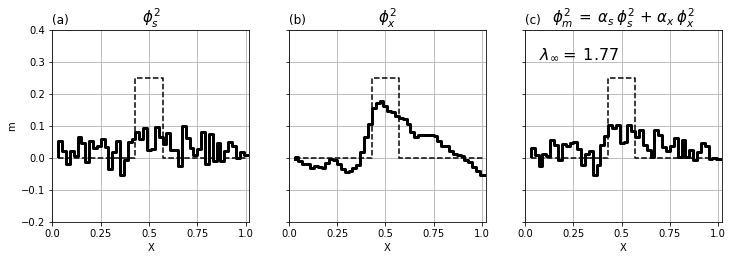

In [7]:
fig = plt.figure(figsize=(12, 12))
label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
true = np.kron(mtrue,np.ones(2))
xx = np.kron(mesh.vectorCCx,np.ones(2))
for ii, mrec in enumerate(models[:3]):
    
# axes[0].plot(survey.dobs)
# axes[0].plot(invProb.dpred)

    axs = plt.subplot(3,3,ii+1)
#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
    axs.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
#     axs.fill_between(xx, 0, true)
#     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

    # axes[1].legend(('True Model', 'Recovered Model'))
    axs.set_ylim(-.2, 0.4)
    axs.set_xlim(0,mesh.vectorNx[-1])
    axs.set_xlabel("X")
    axs.set_xticks(np.linspace(-1,49,5)/50)
    axs.set_xticklabels(np.linspace(0,1,5))
    axs.set_ylabel("m")
#     if ii<6:
#         axs.set_xticklabels([])
#         axs.set_xlabel("")
    if ii%3 != 0:
        axs.set_yticklabels([])
        axs.set_ylabel("")
        

    axs.set_title(label[ii], loc='left')
#     axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    
#     if ii == 0:
    axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
#         axs.fill_between(mesh.vectorCCx,mLP.x, step="pre", alpha=1.)
# #         axs.step(mesh.vectorCCx, mLP.x, lw=2)
#         axs.legend(['True','IRLS', 'BP-Interior'])
#     else:
#         axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    axs.grid('on')
    if alpha_s[ii] == 0:
        axs.set_title('$\phi_x^' + str(int(np.round(p_x[ii]))) +'$', size=15)
    elif alpha_x[ii] == 0:
        axs.set_title('$\phi_s^' + str(int(np.round(p_s[ii]))) +'$', size=15)
    else:
        axs.set_title(r'$\phi_m^' + str(int(np.round(p_x[ii]))) +'\:=\:'+ '\\alpha_s\:\phi_s^' + str(int(np.round(p_s[ii]))) +'$' + r' + $\alpha_x\:\phi_x^' + str(int(p_x[ii])) +'$', size=15) 
        axs.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii][-1]/phi_x_Deriv[ii][-1]*100)/100), size=16)

plt.show()
fig.savefig('Problem1D_Results_l2.png',bbox_inches='tight')

Iter:18phim: 77.78994497628852 $\epsilon$: 0.06242950769699741 phid: dask.array<mul, shape=(), dtype=float64, chunksize=()>


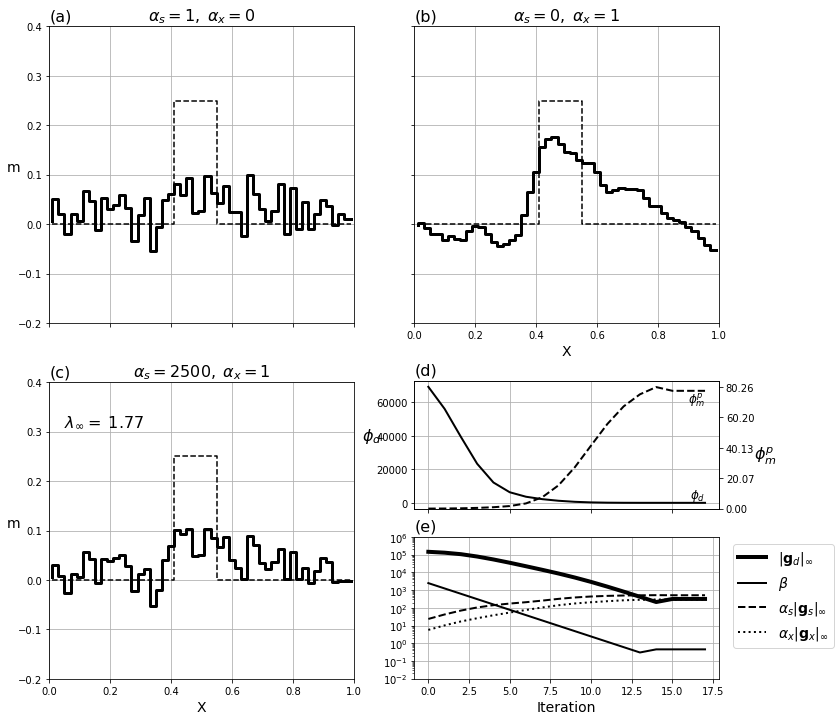

In [9]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2,2,3)
ax2 = plt.subplot(4,2,6)
ax3 = ax2.twinx()

ax4 = plt.subplot(4,2,8)
# 
ax5 = plt.subplot(2,2,1)
ax6 = plt.subplot(2,2,2)

gap = 0

ii = 2
phi_m = (np.r_[phi_s[ii]] + np.r_[phi_x[ii]]).tolist()
beta = betas[ii]
# for phi in iterations[0].phi_m:
#     phi /= (2.*np.max(models[0])*reg_eps_p)


label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
true = np.kron(mtrue,np.ones(2))
xx = np.kron(mesh.vectorCCx,np.ones(2))

#
ax5.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
ax5.set_ylim(-.2, 0.4)
ax5.set_xlim(0,1)
ax5.set_xticklabels("")
ax5.step(mesh.vectorCCx, models[0], c='k', lw=3)
ax5.grid(True)
# ax5.text(0.05,0.35,'$\\alpha_s=\;2500$', size=16)
ax5.set_title("$\\alpha_s=1,\; \\alpha_x=0$",size=16)
ax5.set_title(label[0], loc = 'left', size=16)
ax5.set_xlabel("", size=14)
ax5.set_ylabel("m", size=14, rotation=0)
# ax5.legend(['$m^{true}$'])

# 
ax6.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
ax6.set_ylim(-.2, 0.4)
ax6.set_xlim(0,1)
# ax6.set_xticks(np.linspace(-1,49,5)/50)
ax6.step(mesh.vectorCCx, models[1], c='k', lw=3)
ax6.grid('on')
# ax5.text(0.05,0.35,'$\\alpha_s=\;2500$', size=16)
ax6.set_title("$\\alpha_s=0,\; \\alpha_x=1$",size=16)
ax6.set_title(label[1], loc = 'left', size=16)
ax6.set_xlabel("X", size=14)
ax6.set_ylabel("", size=14, rotation=0)
ax6.set_yticklabels("")
# ax6.legend(['$m^{true}$'])

# plot mix norm
ax1.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
ax1.set_ylim(-.2, 0.4)
ax1.set_xlim(0,1)
# ax1.set_xticks(np.linspace(-1,49,5)/50)
ax1.step(mesh.vectorCCx, models[ii], c='k', lw=3)
ax1.grid('on')
# ax1.text(0.05,0.30,'$\\alpha_s=\;2500$', size=16)
# ax1.text(0.05,0.35,'$\\alpha_x=\;1$', size=16)
ax1.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii][-1]/phi_x_Deriv[ii][-1]*100)/100), size=16)
ax1.set_title(label[2], loc = 'left', size=16)
ax1.set_title("$\\alpha_s=2500,\; \\alpha_x=1$",size=16)
ax1.set_xlabel("X", size=14)
ax1.set_ylabel("m", size=14, rotation=0)
# ax1.legend(['$m^{true}$'])


ax2.plot(phi_d[ii][:gap],'k',lw=2)
ax2.plot(np.r_[range(gap, len(phi_d[ii][gap:])+gap)],phi_d[ii][gap:],'k',lw=2)

ax3.plot(phi_m[:gap], 'k--',lw=2)
ax3.plot(np.r_[range(gap, len(phi_m))],phi_m[gap:],'k--',lw=2)

ax4.semilogy(phi_d_Deriv[ii][:gap],'k',lw=4)
ax4.semilogy(beta[:gap], 'k',lw=2)
ax4.semilogy(phi_s_Deriv[ii][:gap],'k--',lw=2)
ax4.semilogy(phi_x_Deriv[ii][:gap],'k:',lw=2)

ax4.semilogy(np.r_[range(gap, len(beta))],beta[gap:],'k',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_d_Deriv[ii][gap:])+gap)],phi_d_Deriv[ii][gap:],'k',lw=4)
ax4.semilogy(np.r_[range(gap, len(phi_s_Deriv[ii][gap:])+gap)],phi_s_Deriv[ii][gap:],'k--',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_x_Deriv[ii][gap:])+gap)],phi_x_Deriv[ii][gap:],'k:',lw=2)

print("Iter:" +str(len(phi_m)) + "phim: " + str(phi_m[-1]) + ' $\epsilon$: ' + str(eps_p[ii][-1])+" phid: " + str(phi_d[ii][-1]*2))
    


# ax2.text(gap-0.5, np.mean(phi_d[ii]),'IRLS Start',bbox={'facecolor':'white'}, va='center', ha='center', rotation='vertical', size=10)
ax2.set_xlabel('')
ax2.set_xticklabels('')

ax2.set_ylabel('$\phi_d$', size=16, rotation=0)
ax3.set_ylabel('   $\phi_m^p$', size=16, rotation=0)

# ax2.set_ylim([0,1e+4])
ax3.set_ylim([0,np.max(phi_m)*1.05])
ax3.set_yticks(np.round(np.linspace(0,(np.max(phi_m)),5)*100)/100)
ax2.set_xticks(range(0,len(phi_d[ii]),5))
# ax2.set_yticks(np.linspace(0,1e+4,5))
# ax2.set_title('Convergence curves', size=14)
ax2.grid(True)
ax2.text(len(phi_d[ii])-1,phi_d[ii][-1],'$\phi_d$', va='bottom', ha='right',size=12)
ax3.text(len(phi_m)-1,phi_m[-1],'$\phi_m^{p}$', va='top', ha='right',size=12)

ax2.set_title(label[3], loc = 'left', size=16)
ax2.set_position([ax2.get_position().x0, ax2.get_position().y0, ax2.get_position().width, ax2.get_position().height*0.9])
# ax3.grid(True)

# ax5.set_ylabel("", size=16, rotation=0)
# ax5.set_yticks([])
ax4.set_xlabel('Iterations', size=14)
ax4.set_title(label[4], loc = 'left', size=16)
# ax4.set_ylabel('$\\beta$', size=16, rotation=0)
ax4.grid(True)
# ax5.set_xticks(range(0,len(phi_d[0]),5))
# ax5.set_xticklabels(range(0,len(phi_d[0]),5))
ax4.set_xlabel('Iteration', size=14)
# ax4.set_yticks(np.power(10,np.linspace(-2,5,4)).tolist())
ax4.set_ylim([1e-2, 1e+6])
# ax5.set_ylim([0.01, 1e+5])
# ax5.legend(['$\|\\frac{\partial \phi_d}{\partial m}\|_\infty$',
#             '$\\alpha_s\|\\frac{\partial \phi_s^0}{\partial m}\|_\infty$',
#             '$\\alpha_x\|\\frac{\partial \phi_x^2}{\partial m}\|_\infty$'], fontsize=14, bbox_to_anchor=(1.4, 1.00))
ax4.legend(['$\|\mathbf{g}_d\|_\infty$',
            '$\\beta$',
            '$\\alpha_s\|\mathbf{g}_s\|_\infty$',
            '$\\alpha_x\|\mathbf{g}_x\|_\infty$',
            ], fontsize=14, bbox_to_anchor=(1.4, 1.00))

# ax4.text(len(beta)-1,beta[-1],'$\\beta$', va='top', ha='right',size=14)
# ax5.text(len(phi_s_Deriv[0]),phi_s_Deriv[0][-1],'$\|\\frac{\partial \phi_s^p}{\partial m}\|_\infty$', va='bottom', ha='right',size=12)
plt.show()

fig.savefig('Problem1D_l2l2.png',bbox_inches='tight')

Iter:100phim: 60.25300956930069 $\epsilon$: 3.989174824141208e-06 phid: dask.array<mul, shape=(), dtype=float64, chunksize=()>


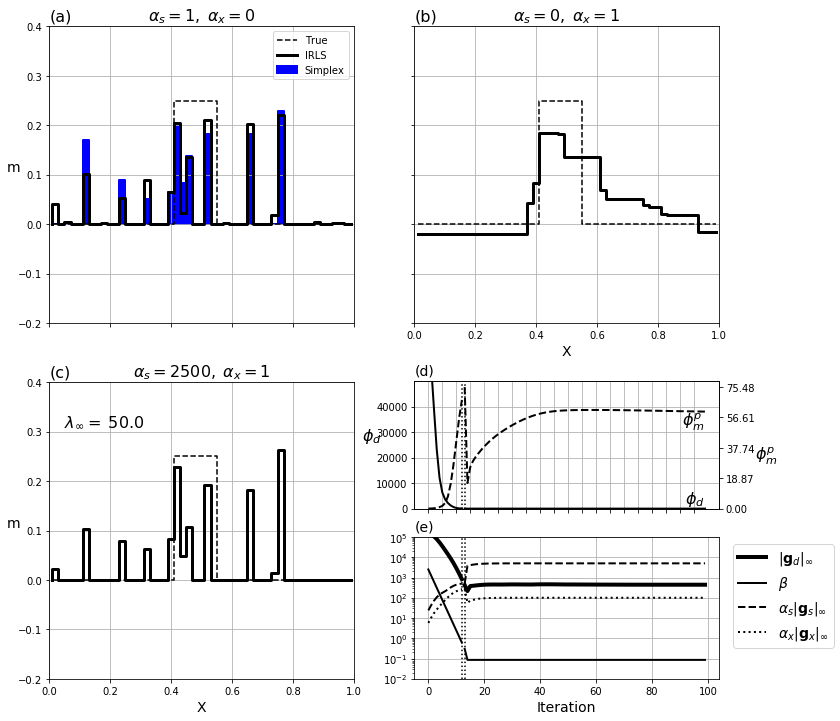

In [10]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2,2,3)
ax2 = plt.subplot(4,2,6)
ax3 = ax2.twinx()

ax4 = plt.subplot(4,2,8)
# 
ax5 = plt.subplot(2,2,1)
ax6 = plt.subplot(2,2,2)

gap = 13

ii = 5
phi_m = (np.r_[phi_s[ii]] + np.r_[phi_x[ii]]).tolist()
beta = betas[ii]
# for phi in iterations[0].phi_m:
#     phi /= (2.*np.max(models[0])*reg_eps_p)


label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
true = np.kron(mtrue,np.ones(2))
xx = np.kron(mesh.vectorCCx,np.ones(2))

#
ax5.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
ax5.set_ylim(-.2, 0.4)
ax5.set_xlim(0,1)
ax5.set_xticklabels("")
ax5.step(mesh.vectorCCx, models[3], c='k', lw=3)
ax5.fill_between(mesh.vectorCCx, mLP.x, color='b', step="pre", linewidth=2)
ax5.legend(["True","IRLS", "Simplex"])
ax5.grid(True)
# ax5.text(0.05,0.35,'$\\alpha_s=\;2500$', size=16)
ax5.set_title("$\\alpha_s=1,\; \\alpha_x=0$",size=16)
ax5.set_title(label[0], loc = 'left', size=16)
ax5.set_xlabel("", size=14)
ax5.set_ylabel("m", size=14, rotation=0)
# ax5.legend(['$m^{true}$'])

# 
ax6.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
ax6.set_ylim(-.2, 0.4)
ax6.set_xlim(0,1)
# ax6.set_xticks(np.linspace(-1,49,5)/50)
ax6.step(mesh.vectorCCx, models[4], c='k', lw=3)
ax6.grid(True)
# ax5.text(0.05,0.35,'$\\alpha_s=\;2500$', size=16)
# ax6.text(0.05,0.30,'$\\alpha_s=\;0$', size=16)
ax6.set_title("$\\alpha_s=0,\; \\alpha_x=1$",size=16)
ax6.set_title(label[1], loc = 'left', size=16)
ax6.set_xlabel("X", size=14)
ax6.set_ylabel("", size=14, rotation=0)
ax6.set_yticklabels("")
# ax6.legend(['$m^{true}$'])

# plot mix norm
ax1.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
ax1.set_ylim(-.2, 0.4)
ax1.set_xlim(0,1)
# ax1.set_xticks(np.linspace(-1,49,5)/50)
ax1.step(mesh.vectorCCx, models[ii], c='k', lw=3)
ax1.grid(True)
# ax1.text(0.05,0.30,'$\\alpha_s=\;2500$', size=16)
# ax1.text(0.05,0.35,'$\\alpha_x=\;1$', size=16)
ax1.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii][-1]/phi_x_Deriv[ii][-1]*100)/100), size=16)
ax1.set_title(label[2], loc = 'left', size=16)
ax1.set_title("$\\alpha_s=2500,\; \\alpha_x=1$",size=16)
ax1.set_xlabel("X", size=14)
ax1.set_ylabel("m", size=14, rotation=0)
# ax1.legend(['$m^{true}$'])


ax2.plot(phi_d[ii][:gap],'k',lw=2)
ax2.plot(np.r_[range(gap, len(phi_d[ii][gap:])+gap)],phi_d[ii][gap:],'k',lw=2)

ax3.plot(phi_m[:gap], 'k--',lw=2)
ax3.plot(np.r_[range(gap, len(phi_m))],phi_m[gap:],'k--',lw=2)

ax4.semilogy(phi_d_Deriv[ii][:gap],'k',lw=4)
ax4.semilogy(beta[:gap], 'k',lw=2)
ax4.semilogy(phi_s_Deriv[ii][:gap],'k--',lw=2)
ax4.semilogy(phi_x_Deriv[ii][:gap],'k:',lw=2)

ax4.semilogy(np.r_[range(gap, len(beta))],beta[gap:],'k',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_d_Deriv[ii][gap:])+gap)],phi_d_Deriv[ii][gap:],'k',lw=4)
ax4.semilogy(np.r_[range(gap, len(phi_s_Deriv[ii][gap:])+gap)],phi_s_Deriv[ii][gap:],'k--',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_x_Deriv[ii][gap:])+gap)],phi_x_Deriv[ii][gap:],'k:',lw=2)

print("Iter:" +str(len(phi_m)) + "phim: " + str(phi_m[-1]) + ' $\epsilon$: ' + str(eps_p[ii][-1])+" phid: " + str(phi_d[ii][-1]*2))
    


# ax2.text(gap-0.5, np.mean(phi_d[ii]),'IRLS Start',bbox={'facecolor':'white'}, va='center', ha='center', rotation='vertical', size=10)
ax2.set_xlabel('')
ax2.set_xticklabels('')

ax2.set_ylabel('$\phi_d$', size=16, rotation=0)
ax3.set_ylabel('   $\phi_m^p$', size=16, rotation=0)

ax2.set_ylim([0,5e+4])
ax3.set_ylim([0,np.max(phi_m)*1.05])
ax3.set_yticks(np.round(np.linspace(0,(np.max(phi_m)),5)*100)/100)
ax2.set_xticks(range(0,len(phi_d[ii]),5))
ax2.plot(np.r_[gap,gap],np.r_[1e-2,5e+5],'k:')
ax2.plot(np.r_[gap-1,gap-1],np.r_[1e-2,5e+5],'k:')
ax2.set_yticks(range(0,50000,10000))
# ax2.set_title('Convergence curves', size=14)
ax2.grid(True)
ax2.text(len(phi_d[ii])-1,phi_d[ii][-1],'$\phi_d$', va='bottom', ha='right',size=16)
ax3.text(len(phi_m)-1,phi_m[-1],'$\phi_m^{p}$', va='top', ha='right',size=16)

ax2.set_title(label[3], loc = 'left', size=14)
ax2.set_position([ax2.get_position().x0, ax2.get_position().y0, ax2.get_position().width, ax2.get_position().height*0.9])
# ax3.grid(True)

# ax5.set_ylabel("", size=16, rotation=0)
# ax5.set_yticks([])
ax4.set_xlabel('Iterations', size=14)
ax4.set_title(label[4], loc = 'left', size=14)
# ax4.set_ylabel('$\\beta$', size=16, rotation=0)
ax4.grid(True)
# ax5.set_xticks(range(0,len(phi_d[0]),5))
# ax5.set_xticklabels(range(0,len(phi_d[0]),5))
ax4.plot(np.r_[gap,gap],np.r_[1e-2,2e+5],'k:')
ax4.plot(np.r_[gap-1,gap-1],np.r_[1e-2,2e+5],'k:')
ax4.set_xlabel('Iteration', size=14)
# ax4.set_yticks(np.power(10,np.linspace(-2,5,4)).tolist())
ax4.set_ylim([0.01, 1e+5])
# ax5.set_ylim([0.01, 1e+5])
# ax5.legend(['$\|\\frac{\partial \phi_d}{\partial m}\|_\infty$',
#             '$\\alpha_s\|\\frac{\partial \phi_s^0}{\partial m}\|_\infty$',
#             '$\\alpha_x\|\\frac{\partial \phi_x^2}{\partial m}\|_\infty$'], fontsize=14, bbox_to_anchor=(1.4, 1.00))
ax4.legend(['$\|\mathbf{g}_d\|_\infty$',
            '$\\beta$',
            '$\\alpha_s\|\mathbf{g}_s\|_\infty$',
            '$\\alpha_x\|\mathbf{g}_x\|_\infty$',
            ], fontsize=14, bbox_to_anchor=(1.4, 1.00))

# ax4.text(len(beta)-1,beta[-1],'$\\beta$', va='top', ha='right',size=14)
# ax5.text(len(phi_s_Deriv[0]),phi_s_Deriv[0][-1],'$\|\\frac{\partial \phi_s^p}{\partial m}\|_\infty$', va='bottom', ha='right',size=12)
plt.show()

fig.savefig('Problem1D_Results_l1',bbox_inches='tight')

In [11]:
regAll[9].eps_p

3.1519406017905838e-06

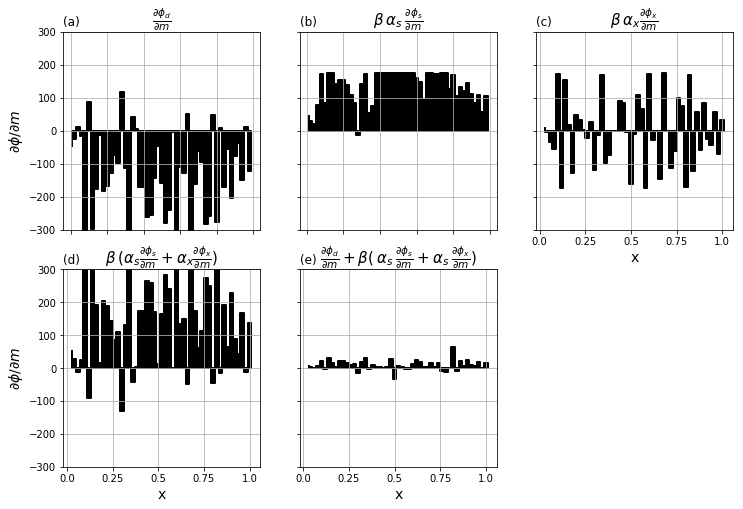

In [12]:
fig = plt.figure(figsize=(12, 8))
label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
ind = 9

#for ii in range(prob.F.shape4[0]):
dphid = dmis.deriv(models[ind])
dphims = betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])
dphimx = betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])
phims = regAll[ind].objfcts[0](models[ind])
phimx = regAll[ind].objfcts[1](models[ind])
    
axs = plt.subplot(2,3,1)
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphid, color= 'k',step="pre", linewidth=2,)
# axs.fill_between(mesh.vectorCCx,dphimx, color= 'k', step="pre", linestyle='-.',alpha=0.3, linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((models[ind]), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title('$\\frac{\partial \phi_d }{ \partial m}$', size=15)
# axs.set_xticks([])
axs.set_xticklabels("")
# axs.set_xlabel("x", size=14)
axs.set_ylabel("$\partial \phi / \partial m$", size=14)
axs.set_title(label[0], loc='left')
axs.set_ylim([-300, 300])


axs = plt.subplot(2,3,2)
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.fill_between(mesh.vectorCCx,dphims, color= 'k',step="pre", linestyle='--',alpha=0.8,)
axs.fill_between(mesh.vectorCCx,dphims, color= 'k', step="pre", linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((models[ind]), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title('$\\beta \: \\alpha_s\:\\frac{\partial \phi_s }{ \partial m}$', size=15)
# axs.set_xticks([])
axs.set_xticklabels("")
# axs.set_yticks([])
axs.set_yticklabels("")
axs.set_title(label[1], loc='left')
axs.set_ylim([-300, 300])


axs = plt.subplot(2,3,3)
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphimx, color= 'k', step="pre", linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((models[ind]), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title('$\\beta \: \\alpha_x \\frac{\partial \phi_x }{ \partial m}$', size=15)
axs.set_xticks(np.linspace(-1,49,5)/50)
axs.set_xticklabels(np.linspace(0,1,5))
axs.set_xlabel("x", size=14)
# axs.set_yticks([])
axs.set_yticklabels("")
axs.set_title(label[2], loc='left')
axs.set_ylim([-300, 300])


axs = plt.subplot(2,3,4)
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphimx+dphims, color= 'k', step="pre", linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((models[ind]), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title(
            '$\\beta \:( \\alpha_s \\frac{\partial \phi_s }{ \partial m}+ \\alpha_x \\frac{\partial \phi_x }{ \partial m})$', size=15)
axs.set_xticks(np.linspace(-1,49,5)/50)
axs.set_xticklabels(np.linspace(0,1,5))
axs.set_xlabel("x", size=14)
axs.set_ylabel("$\partial \phi / \partial m$", size=14)
axs.set_title(label[3], loc='left')
axs.set_ylim([-300, 300])


axs = plt.subplot(2,3,5)
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphid + dphimx+dphims, color= 'k', step="pre", linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((models[ind]), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title( 
            '$\\frac{\partial \phi_d }{ \partial m} + \\beta (\:\\alpha_s\: \\frac{\partial \phi_s }{ \partial m}+ \\alpha_s\:\\frac{\partial \phi_x }{ \partial m})$', size = 15)
axs.set_xticks(np.linspace(-1,49,5)/50)
axs.set_xticklabels(np.linspace(0,1,5))
axs.set_xlabel("x", size=14)
# axs.set_yticks([])
axs.set_yticklabels("")
axs.grid(True)
axs.set_title(label[4], loc='left')
axs.set_ylim([-300, 300])


# axs = plt.subplot(2,3,6)
# columns = ['$\partial \phi_s / \partial m$', '$\partial \phi_x / \partial m$', '$\lambda$']
# rows = ["$\mathbf{l_1}$", "$\mathbf{l_2}$", "$\mathbf{l_\infty}$"]
# # columns = ("1", "2")
# # rows = ["$\|\cdot\|_1$", "$\|\cdot\|_2$", "$\|\cdot\|_\infty$"]

# cell_text = [['%1.1f' % np.sum(np.abs(dphims)), '%1.1f' % np.sum(np.abs(dphimx)),'%1.2f' % (np.sum(np.abs(dphimx))/np.sum(np.abs(dphims)))]]
# cell_text.append(['%1.1f' % np.sum(dphims**2.), '%1.1f' % np.sum(dphimx**2.), '%1.2f' % (np.sum(dphimx**2.)/np.sum(dphims**2.))])
# cell_text.append(['%1.1f' % np.max(np.abs(dphims)), '%1.1f' % np.max(np.abs(dphimx)), '%1.2f' % (np.max(np.abs(dphimx))/np.max(np.abs(dphims)))])

# table = plt.table(cellText=cell_text,
#                       rowLabels=rows,
#                       colLabels=columns,
#                       loc='upper center',
#                          colWidths=[.25,.25,.25])

# pos = axs.get_position()
# axs.set_position([pos.x0, pos.y0-0.1, pos.width, pos.height])
# table.set_fontsize(14)
# table.scale(1.55, 1.75)  # may help
# axs.set_title('Summary Table', size=16)
# axs.axis('tight')
# axs.axis('off')
# print("phisMax/phixMax" + str((betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])).max()/(betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])).max()))
# print("phidMax: " + str(dphid.max()) + "phisMax: " + str(dphims.max()) + "phixMax: " + str(dphimx.max()) )
# print("phi_ms:" + str(phims))
# print("phi_mx:" + str(phimx))
# print("l2-dphis:" + str(np.sum(dphims**2.)) + " l2-dphix:" + str(np.sum(dphimx**2.)))
# print("l1-dphis:" + str(np.sum(dphims**2.)) + " l2-dphix:" + str(np.sum(dphimx**2.)))

# axs.plot(dphis+dphims+dphimx,'k')
fig.savefig('Problem1D_l2l2_dphi.png',bbox_inches='tight')
plt.show()

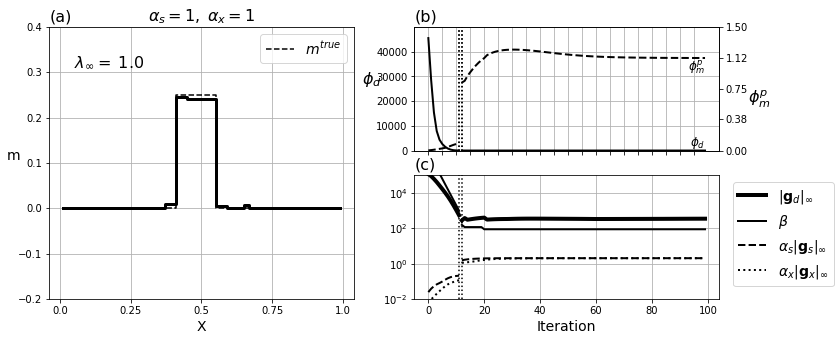

In [13]:
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = ax2.twinx()

ax4 = plt.subplot(2,2,4)
# ax5 = ax4.twinx()

gap = 12

ii = 9
phi_m = (np.r_[phi_s[ii]] + np.r_[phi_x[ii]]).tolist()
beta = betas[ii]
# for phi in iterations[0].phi_m:
#     phi /= (2.*np.max(models[0])*reg_eps_p)


true = np.kron(mtrue,np.ones(2))
xx = np.kron(mesh.vectorCCx,np.ones(2))


#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
ax1.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
#     axs.fill_between(xx, 0, true)
#     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

# axes[1].legend(('True Model', 'Recovered Model'))
ax1.set_ylim(-.2, 0.4)
ax1.set_xticks(np.linspace(0,50,5)/50)
ax1.set_xticklabels(np.linspace(0,1,5))
#     ax1.set_xticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$'])




ax1.step(mesh.vectorCCx, models[ii], c='k', lw=3)
ax1.grid('on')
# ax1.text(0.05,0.35,'$\\alpha_s=\;50$', size=16)
# ax1.text(0.05,0.30,'$\\alpha_x=\;1$', size=16)
ax1.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii][-1]/phi_x_Deriv[ii][-1]*100)/100), size=16)


ax2.plot(phi_d[ii][:gap],'k',lw=2)
ax2.plot(np.r_[range(gap, len(phi_d[ii][gap:])+gap)],phi_d[ii][gap:],'k',lw=2)
# axs.legend(['Start of IRLS'])
#     ax3.text(len(phi_m),phi_m[-1],'$\gamma=$' + str(coolFact[ii]) + ', $\epsilon^{(k)}=10^{' + str(int(np.log10(eps_p[ii][-1])))+'}$', va='bottom', ha='right',size=12)
#     ax3.text(len(phi_m),phi_m[-1],'$\eta=$'+str(coolFact[ii]), va='bottom', ha='left',size=12)
#     ax3.scatter(len(phi_m),phi_m[-1],15,c='k')
ax3.plot(np.r_[phi_m[:gap]], 'k--',lw=2)
ax3.plot(np.r_[range(gap, len(phi_m))],phi_m[gap:],'k--',lw=2)

ax4.semilogy(phi_d_Deriv[ii][:gap],'k',lw=4)
ax4.semilogy(np.r_[beta[:gap]], 'k',lw=2)
ax4.semilogy(np.r_[phi_s_Deriv[ii][:gap]],'k--',lw=2)
ax4.semilogy(np.r_[phi_x_Deriv[ii][:gap]],'k:',lw=2)

ax4.semilogy(np.r_[range(gap, len(beta))],beta[gap:],'k',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_d_Deriv[ii][gap:])+gap)],phi_d_Deriv[ii][gap:],'k',lw=4)
ax4.semilogy(np.r_[range(gap, len(phi_s_Deriv[ii][gap:])+gap)],phi_s_Deriv[ii][gap:],'k--',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_x_Deriv[ii][gap:])+gap)],phi_x_Deriv[ii][gap:],'k:',lw=2)
ax4.semilogy(np.r_[gap,gap],np.r_[0.01,1e+5],'k:')
ax4.semilogy(np.r_[gap-1,gap-1],np.r_[0.01,1e+5],'k:')
#     ax3.text(len(phi_m),phi_m[-1],'$\gamma=$' + str(coolFact[ii]) + ', $\epsilon^{(k)}=10^{' + str(int(np.log10(eps_p[ii][-1])))+'}$', va='bottom', ha='right',size=12)
#     ax3.text(len(phi_m),phi_m[-1],'$\eta=$'+str(coolFact[ii]), va='bottom', ha='left',size=12)
#     ax5.scatter(len(phi_m),phi_m[-1],15,c='k')


# print("Iter:" +str(len(phi_m)) + "phim: " + str(phi_m[-1]) + ' $\epsilon$: ' + str(eps_p[ii][-1])+" phid: " + str(phi_d[ii][-1]*2))
    
ax1.set_title(label[0], loc='left', size=16)
ax1.set_title("$\\alpha_s=1,\; \\alpha_x=1$",size=16)
ax1.set_xlabel("X", size=14)
ax1.set_ylabel("m", size=14, rotation=0)
ax1.legend(['$m^{true}$'], fontsize=14)
# ax2.text(gap-0.5, np.mean(phi_d[ii]),'IRLS Start',bbox={'facecolor':'white'}, va='center', ha='center', rotation='vertical', size=10)
ax2.set_xlabel('')
ax2.set_xticklabels('')
ax2.plot(np.r_[gap,gap],np.r_[1e-2,1e+5],'k:')
ax2.plot(np.r_[gap-1,gap-1],np.r_[1e-2,1e+5],'k:')
ax2.set_ylabel('$\phi_d$', size=16, rotation=0)
ax3.set_ylabel('   $\phi_m^p$', size=16, rotation=0)

ax2.set_ylim([0,5e+4])
ax3.set_ylim([0,1.5])
ax3.set_yticks(np.round(np.linspace(0,1.5,5)*100)/100)
ax2.set_xticks(range(0,len(phi_d[ii]),5))
ax2.plot(np.r_[gap,gap],np.r_[1e-2,5e+5],'k:')
ax2.plot(np.r_[gap-1,gap-1],np.r_[1e-2,5e+5],'k:')
ax2.set_yticks(range(0,50000,10000))
# ax2.set_title('Convergence curves', size=14)
ax2.grid(True)
ax2.text(len(phi_d[ii])-1,phi_d[ii][-1],'$\phi_d$', va='bottom', ha='right',size=12)
ax3.text(len(phi_m)-1,phi_m[-1],'$\phi_m^{p}$', va='top', ha='right',size=12)

ax2.set_title(label[1], loc='left', size=16)
# ax3.grid(True)

# ax5.set_ylabel("", size=16, rotation=0)
# ax5.set_yticks(np.power(10,np.linspace(-2,5,4)).tolist())
ax4.set_xlabel('Iterations', size=16)
ax4.set_title('(c)', loc = 'left', size=16)
# ax4.set_ylabel('$\\beta$', size=16, rotation=0)
ax4.grid(True)
# ax5.set_xticks(range(0,len(phi_d[ii]),5))
# ax5.set_xticklabels(range(0,len(phi_d[ii]),5))
ax4.set_xlabel('Iteration', size=14)
# ax4.set_yticks(np.power(10,np.linspace(-2,5,4)).tolist())
ax4.set_ylim([0.01, 1e+5])
# ax5.set_ylim([0.01, 1e+5])
ax4.legend(['$\|\mathbf{g}_d\|_\infty$',
            '$\\beta$',
            '$\\alpha_s\|\mathbf{g}_s\|_\infty$',
            '$\\alpha_x\|\mathbf{g}_x\|_\infty$',
            ], fontsize=14, bbox_to_anchor=(1.4, 1.00))
# ax4.text(len(beta)-1,beta[-1],'$\\beta$', va='bottom', ha='right',size=14)
# ax5.text(len(phi_s_Deriv[0]),phi_s_Deriv[0][-1],'$\|\\frac{\partial \phi_s^p}{\partial m}\|_\infty$', va='bottom', ha='right',size=12)
plt.show()

fig.savefig('Problem1D_l1l1_finiteDiff.png',bbox_inches='tight')

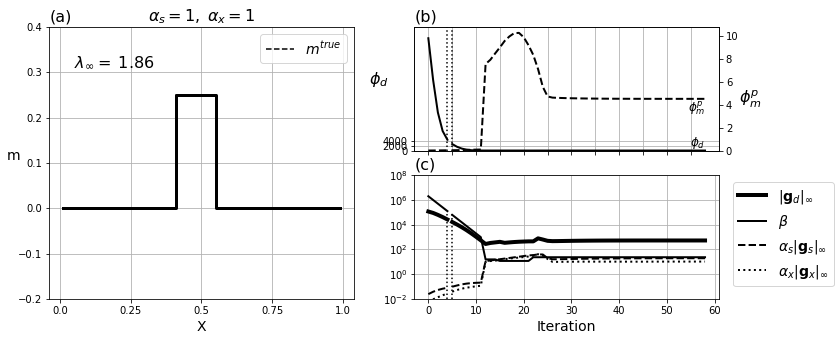

In [14]:
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = ax2.twinx()

ax4 = plt.subplot(2,2,4)
# ax5 = ax4.twinx()

gap = 5

ii = 8
phi_m = (np.r_[phi_s[ii]] + np.r_[phi_x[ii]]).tolist()
beta = betas[ii]
# for phi in iterations[0].phi_m:
#     phi /= (2.*np.max(models[0])*reg_eps_p)


true = np.kron(mtrue,np.ones(2))
xx = np.kron(mesh.vectorCCx,np.ones(2))


#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
ax1.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
#     axs.fill_between(xx, 0, true)
#     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

# axes[1].legend(('True Model', 'Recovered Model'))
ax1.set_ylim(-.2, 0.4)
ax1.set_xticks(np.linspace(0,50,5)/50)
ax1.set_xticklabels(np.linspace(0,1,5))
#     ax1.set_xticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$'])




ax1.step(mesh.vectorCCx, models[ii], c='k', lw=3)
ax1.grid('on')
# ax1.text(0.05,0.35,'$\\alpha_s=\;50$', size=16)
# ax1.text(0.05,0.30,'$\\alpha_x=\;1$', size=16)
ax1.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii][-1]/phi_x_Deriv[ii][-1]*100)/100), size=16)


ax2.plot(phi_d[ii][:gap],'k',lw=2)
ax2.plot(np.r_[range(gap, len(phi_d[ii][gap:])+gap)],phi_d[ii][gap:],'k',lw=2)
# axs.legend(['Start of IRLS'])
#     ax3.text(len(phi_m),phi_m[-1],'$\gamma=$' + str(coolFact[ii]) + ', $\epsilon^{(k)}=10^{' + str(int(np.log10(eps_p[ii][-1])))+'}$', va='bottom', ha='right',size=12)
#     ax3.text(len(phi_m),phi_m[-1],'$\eta=$'+str(coolFact[ii]), va='bottom', ha='left',size=12)
#     ax3.scatter(len(phi_m),phi_m[-1],15,c='k')
ax3.plot(phi_m[:gap], 'k--',lw=2)
ax3.plot(np.r_[range(gap, len(phi_m))],phi_m[gap:],'k--',lw=2)

ax4.semilogy(phi_d_Deriv[ii][:gap],'k',lw=4)
ax4.semilogy(beta[:gap], 'k',lw=2)
ax4.semilogy(phi_s_Deriv[ii][:gap],'k--',lw=2)
ax4.semilogy(phi_x_Deriv[ii][:gap],'k:',lw=2)

ax4.semilogy(np.r_[range(gap, len(beta))],beta[gap:],'k',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_d_Deriv[ii][gap:])+gap)],phi_d_Deriv[ii][gap:],'k',lw=4)
ax4.semilogy(np.r_[range(gap, len(phi_s_Deriv[ii][gap:])+gap)],phi_s_Deriv[ii][gap:],'k--',lw=2)
ax4.semilogy(np.r_[range(gap, len(phi_x_Deriv[ii][gap:])+gap)],phi_x_Deriv[ii][gap:],'k:',lw=2)
ax4.semilogy(np.r_[gap,gap],np.r_[0.01,1e+5],'k:')
ax4.semilogy(np.r_[gap-1,gap-1],np.r_[0.01,1e+5],'k:')
#     ax3.text(len(phi_m),phi_m[-1],'$\gamma=$' + str(coolFact[ii]) + ', $\epsilon^{(k)}=10^{' + str(int(np.log10(eps_p[ii][-1])))+'}$', va='bottom', ha='right',size=12)
#     ax3.text(len(phi_m),phi_m[-1],'$\eta=$'+str(coolFact[ii]), va='bottom', ha='left',size=12)
#     ax5.scatter(len(phi_m),phi_m[-1],15,c='k')


# print("Iter:" +str(len(phi_m)) + "phim: " + str(phi_m[-1]) + ' $\epsilon$: ' + str(eps_p[ii][-1])+" phid: " + str(phi_d[ii][-1]*2))
    
ax1.set_title(label[0], loc='left', size=16)
ax1.set_title("$\\alpha_s=1,\; \\alpha_x=1$",size=16)
ax1.set_xlabel("X", size=14)
ax1.set_ylabel("m", size=14, rotation=0)
ax1.legend(['$m^{true}$'], fontsize=14)
# ax2.text(gap-0.5, np.mean(phi_d[ii]),'IRLS Start',bbox={'facecolor':'white'}, va='center', ha='center', rotation='vertical', size=10)
ax2.set_xlabel('')
ax2.set_xticklabels('')
ax2.plot(np.r_[gap,gap],np.r_[1e-2,1e+5],'k:')
ax2.plot(np.r_[gap-1,gap-1],np.r_[1e-2,1e+5],'k:')
ax2.set_ylabel('$\phi_d$', size=16, rotation=0)
ax3.set_ylabel('   $\phi_m^p$', size=16, rotation=0)

ax2.set_ylim([0,np.r_[phi_d[ii]].max()*1.1])
ax3.set_ylim([0,np.max(phi_m)*1.05])
ax2.set_xticks(range(0,len(phi_d[ii]),5))
ax2.set_yticks(range(0,6000,2000))
# ax2.set_title('Convergence curves', size=14)
ax2.grid(True)
ax2.text(len(phi_d[ii])-1,phi_d[ii][-1],'$\phi_d$', va='bottom', ha='right',size=12)
ax3.text(len(phi_m)-1,phi_m[-1],'$\phi_m^{p}$', va='top', ha='right',size=12)

ax2.set_title(label[1], loc='left', size=16)
# ax3.grid(True)

# ax5.set_ylabel("", size=16, rotation=0)
# ax5.set_yticks(np.power(10,np.linspace(-2,5,4)).tolist())
ax4.set_xlabel('Iterations', size=16)
ax4.set_title('(c)', loc = 'left', size=16)
# ax4.set_ylabel('$\\beta$', size=16, rotation=0)
ax4.grid(True)
# ax5.set_xticks(range(0,len(phi_d[ii]),5))
# ax5.set_xticklabels(range(0,len(phi_d[ii]),5))
ax4.set_xlabel('Iteration', size=14)
# ax4.set_yticks(np.power(10,np.linspace(-2,5,4)).tolist())
ax4.set_ylim([1e-2, 1e+8])
# ax5.set_ylim([0.01, 1e+5])
ax4.legend(['$\|\mathbf{g}_d\|_\infty$',
            '$\\beta$',
            '$\\alpha_s\|\mathbf{g}_s\|_\infty$',
            '$\\alpha_x\|\mathbf{g}_x\|_\infty$',
            ], fontsize=14, bbox_to_anchor=(1.4, 1.00))
# ax4.text(len(beta)-1,beta[-1],'$\\beta$', va='bottom', ha='right',size=14)
# ax5.text(len(phi_s_Deriv[0]),phi_s_Deriv[0][-1],'$\|\\frac{\partial \phi_s^p}{\partial m}\|_\infty$', va='bottom', ha='right',size=12)
plt.show()

fig.savefig('Problem1D_l0l0.png',bbox_inches='tight', dpi=600)

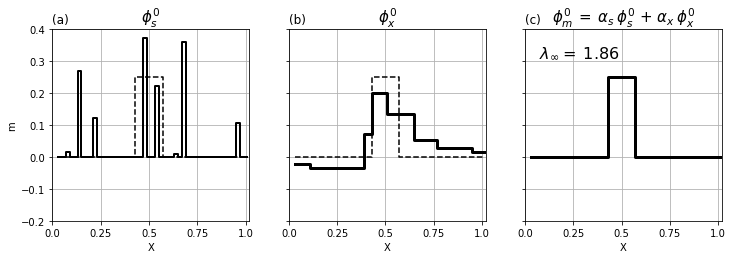

In [15]:
fig = plt.figure(figsize=(12, 12))
for ii, mrec in enumerate(models[6:-1]):
    
# axes[0].plot(survey.dobs)
# axes[0].plot(invProb.dpred)

    axs = plt.subplot(3,3,ii+1)
#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
    axs.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
#     axs.fill_between(xx, 0, true)
#     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

    # axes[1].legend(('True Model', 'Recovered Model'))
    axs.set_ylim(-.2, 0.4)
    axs.set_xlim(0,mesh.vectorNx[-1])
    axs.set_xlabel("X")
    axs.set_xticks(np.linspace(-1,49,5)/50)
    axs.set_xticklabels(np.linspace(0,1,5))
    axs.set_ylabel("m")
#     if ii<6:
#         axs.set_xticklabels([])
#         axs.set_xlabel("")
    if ii%3 != 0:
        axs.set_yticklabels([])
        axs.set_ylabel("")
        
    
    axs.set_title(label[ii], loc='left')
#     axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    
#     if ii == 0:
    if ii == 0:
#         axs.fill_between(mesh.vectorCCx,mLP.x, step="pre", alpha=1.)
        axs.step(mesh.vectorCCx, mrec, 'k-', lw=2)
        
#         axs.step(mesh.vectorCCx, mLP.x, lw=2)
#         axs.legend(['True', 'IRLS', 'Simplex'])
    else:
        axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
#         axs.fill_between(mesh.vectorCCx,mLP.x, step="pre", alpha=1.)
# #         axs.step(mesh.vectorCCx, mLP.x, lw=2)
#         axs.legend(['True','IRLS', 'BP-Interior'])
#     else:
#         axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    axs.grid('on')
    if alpha_s[ii] == 0:
        axs.set_title('$\phi_x^' + str(int(np.round(p_x[ii+6]))) +'$', size=15)
    elif alpha_x[ii] == 0:
        axs.set_title('$\phi_s^' + str(int(np.round(p_s[ii+6]))) +'$', size=15)
    else:
        axs.set_title('$\phi_m^' + str(int(np.round(p_x[ii+6]))) +'\:=\:'+ '\\alpha_s\:\phi_s^' + str(int(np.round(p_s[ii+6]))) +'$' + ' + $\\alpha_x\:\phi_x^' + str(int(p_x[ii+6])) +'$', size=15) 
        axs.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii+6][-1]/phi_x_Deriv[ii+6][-1]*100)/100), size=16)

        plt.show()
fig.savefig('Problem1D_Results_l0.png',bbox_inches='tight')

# Cooled eta 

In [107]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm
eps_p = []
eps_q = []
lp = []
lq = []
phi_s = []
phi_x = []
phi_d = []
scaledIRLS=True
def invSetter(p_s, p_x, a_s, a_x, eps_p, eps_q, coolFact):
       
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd
    
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)
    
    reg = Regularization.Sparse(mesh, mapping=idenMap, gradientType='components', scaledIRLS=scaledIRLS)
    reg.mref = mref
#     reg.cell_weights = wr
    reg.norms = np.c_[p_s, p_x]
#     reg.scales = np.c_[1,1]
    reg.eps_p = eps_p
    reg.eps_q = eps_q
    reg.alpha_x = a_x
    reg.alpha_s = a_s

    opt = Optimization.ProjectedGNCG(
        maxIter=200, lower=-2., upper=2.,
        maxIterLS=20, maxIterCG=100, tolCG=1e-3,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+5)
    update_Jacobi = Directives.UpdatePreconditioner()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms
    
    saveDict = Directives.SaveOutputDictEveryIteration()
    
    IRLS = Directives.Update_IRLS(maxIRLSiter=200, minGNiter=1, updateGamma=False,
                                  coolEpsFact=coolFact, f_min_change = 1e-4, beta_tol = 5e-1,
                                 chifact_start=1.,chifact_target=1., coolEps_p=True, coolEps_q=True,
                                 floorEps_p = 1e-8, floorEps_q = 1e-8, floorEpsEnforced=True)

    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(np.random.rand(mesh.nC)*1e-3)
    return mrec, invProb, dmis, saveDict.outDict, reg

coolFact = [1.125]
p_s = [0]*len(coolFact)#mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist()
p_x = [2]*len(coolFact)#mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist()
alpha_x = [1]*len(coolFact)#np.r_[0, 1, 1].tolist()*3
alpha_s = [1]*len(coolFact)#np.r_[1, 0, 1].tolist()*3

eps_p0,eps_q0 = 1e-1, 1e-1
models = []
dpred = []
iterations = []
reg_eps = []
betas = []
regAll = []
phi_s_Deriv = []
phi_x_Deriv = []
phi_d_Deriv = []
for jj, (p, q, a_s, a_x, coolfact) in enumerate(zip(p_s, p_x, alpha_s, alpha_x, coolFact)):

    mm, invProb, dmis, outDict, reg = invSetter(p, q, a_s, a_x, eps_p0, eps_q0, coolfact)
    print(len(outDict.keys()))
    models += [mm]
    dpred += [invProb.dpred]
    regAll += [reg]
#     iterations += [[iterate]]
    eps_p.append([outDict[ii+1]['eps_p'] for ii in range(invProb.opt.iter)])
    eps_q.append([outDict[ii+1]['eps_q'] for ii in range(invProb.opt.iter)])
    lp.append([outDict[ii+1]['lps'] for ii in range(invProb.opt.iter)])
    lq.append([outDict[ii+1]['lpx'] for ii in range(invProb.opt.iter)])
    phi_s.append([a_s*getLpNorm(outDict[ii+1]['m'], lp[jj][ii], eps_p[jj][ii]) for ii in range(invProb.opt.iter)])
    phi_x.append([a_x*getLpNorm(outDict[ii+1]['m'], lq[jj][ii], eps_q[jj][ii]) for ii in range(invProb.opt.iter)])
    phi_s_Deriv.append([a_s*getLsNormDeriv(outDict[ii+1]['m'], lp[jj][ii], eps_p[jj][ii], scaledIRLS) for ii in range(invProb.opt.iter)])
    phi_x_Deriv.append([a_x*getLxNormDeriv(outDict[ii+1]['m'], lq[jj][ii], eps_q[jj][ii], scaledIRLS) for ii in range(invProb.opt.iter)])
    phi_d_Deriv.append([np.dot(F.T,(np.dot(F,outDict[ii+1]['m'])-survey.dobs)/wd**2.).max() for ii in range(invProb.opt.iter)])

    #     phi_s.append([outDict[ii+1]['phi_ms'] for ii in range(invProb.opt.iter)])
#     phi_x.append([outDict[ii+1]['phi_msx'] for ii in range(invProb.opt.iter)])
    phi_d.append([outDict[ii+1]['phi_d'] for ii in range(invProb.opt.iter)])
    betas.append([outDict[ii+1]['beta'] for ii in range(invProb.opt.iter)])
    reg_eps.append([reg.eps_p, reg.eps_q])
    

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Approximated diag(JtJ) with linear operator
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-05-30-08-42.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+05  8.53e+04  1.25e-05  8.53e+04    1.41e+01      0              
Start CG solve
CG solve time: 0.22199678421020508
   1  5.00e+04  1.49e+03  3.35e-02  3.16e+03    1.39e+01      0              
Start CG solve
CG solve time: 0.2220001220703125
   2  2.50e+04  7.86e+02  4.34e-02  1.87e+03    1.39e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.2609994411468506
   3  1.25e+04  3.59e+02  5.53e-02  1.05e+03    1.39e+01      0   Skip BFGS  
Start CG solve
CG solv

Start CG solve
CG solve time: 0.2145693302154541
delta phim: 1.608e-02
  50  8.79e+02  3.58e+00  5.28e-02  5.00e+01    1.23e+01      0              
Start CG solve
CG solve time: 0.21297788619995117
delta phim: 8.897e-03
  51  8.79e+02  3.34e+00  5.22e-02  4.92e+01    1.27e+01      0              
Start CG solve
CG solve time: 0.22122883796691895
delta phim: 7.357e-03
  52  8.79e+02  3.04e+00  5.13e-02  4.81e+01    1.27e+01      0              
Start CG solve
CG solve time: 0.2030041217803955
delta phim: 1.662e-02
  53  8.79e+02  3.01e+00  5.09e-02  4.77e+01    1.27e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.2050018310546875
delta phim: 2.371e-03
  54  8.79e+02  3.04e+00  5.07e-02  4.76e+01    1.27e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.21700072288513184
delta phim: 1.973e-04
  55  8.79e+02  3.06e+00  5.06e-02  4.75e+01    1.26e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.18699955940246582
delta phim: 2.887e-03
  56  8.79e+02  3.07e+00  5.05e

ValueError: operands could not be broadcast together with shapes (50,) (51,) 

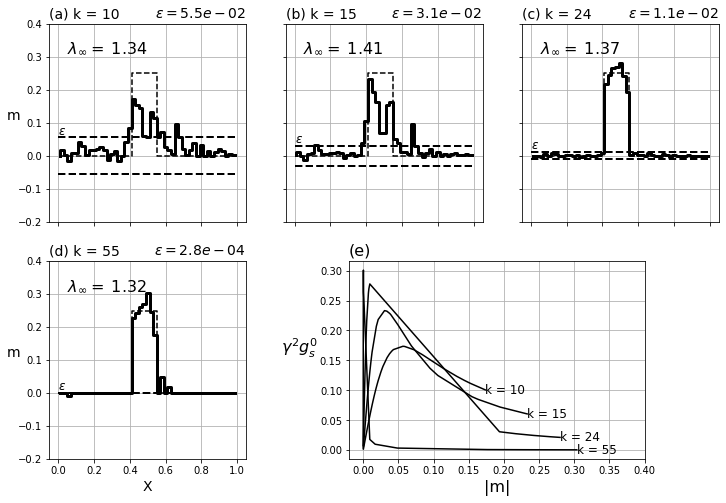

In [112]:
fig = plt.figure(figsize=(12, 8))
label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(2,2,2)
# ax3 = ax2.twinx()

ax5 = plt.subplot(2,3,6)
# ax5 = ax4.twinx()

gap = 6
count = 0
for ii, iterate in enumerate([10,15,24,55]):
    
    m = outDict[iterate+1]['m']
    ax1 = plt.subplot(2,3,ii+1)
    true = np.kron(mtrue,np.ones(2))
    xx = np.kron(mesh.vectorCCx,np.ones(2))

    #     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
    ax1.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
    #     axs.fill_between(xx, 0, true)
    #     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

    # axes[1].legend(('True Model', 'Recovered Model'))
    ax1.set_ylim(-.2, 0.4)
    if ii <3:
        ax1.set_xticklabels([])
        ax1.set_xlabel("", size=14)
    else:
        ax1.set_xlabel("X", size=14)
        
    if (ii == 0) or (ii == 3):
        ax1.set_ylabel("m", size=14, rotation=0)
    else:
        ax1.set_ylabel("")
        ax1.set_yticklabels([])
    ax1.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(np.abs(phi_s_Deriv[0][iterate]).max()/np.abs(phi_x_Deriv[0][iterate]).max()*100)/100), size=16)

#     ax1.set_xticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$'])
    ax1.plot(np.r_[0,1],np.r_[eps_p[0][iterate], eps_p[0][iterate]], 'k--', linewidth=2)
    ax1.plot(np.r_[0,1],np.r_[-eps_p[0][iterate], -eps_p[0][iterate]], 'k--', linewidth=2)
    ax1.text(0,eps_p[0][iterate],"$\epsilon$", va='bottom', ha='left', size=12)

    ax1.step(mesh.vectorCCx, m, lw=3, c='k')
    ax1.grid('on')
    ax1.set_title(label[ii] + " k = " + str(iterate), loc='left', size=14)
    ax1.set_title("$\epsilon={0:0.1e}".format(eps_p[0][iterate]) + '}$', loc='right', size=14)
    


    dphim = 2*np.abs(m).max()*eps_p[0][iterate]*np.sort(np.abs(m))/(np.sort(np.abs(m))**2. + eps_p[0][iterate]**2.)
    ax5.plot(np.sort(np.abs(m)), dphim, c='k')
    ax5.text(np.abs(m).max(), dphim[-1], va='center', ha='left', s="k = " + str(iterate), size=12)
    
ax5.set_xlabel('|m|',size=16)
ax5.set_ylabel('$\gamma^2 g_s^0$', rotation=0, labelpad=20, size=16)
ax5.set_xlim([-0.02, 0.4])
ax5.grid(True)
ax5.set_position([ax5.get_position().x0-0.2, ax5.get_position().y0, ax5.get_position().width*1.5, ax5.get_position().height])
ax5.set_title(label[ii+1], loc='left', size=16)

fig.savefig('Problem1D_l0l2_Cooled_Eta_Iterates.png',bbox_inches='tight', dpi=200)

In [113]:
len(phi_x_Deriv[0][1])

50

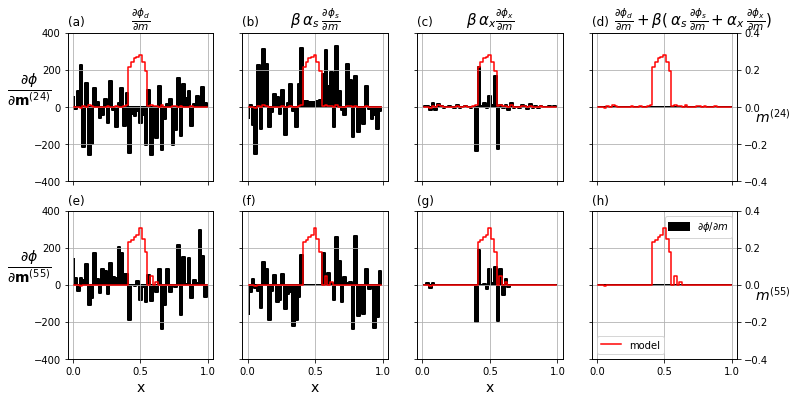

In [136]:
fig = plt.figure(figsize=(12, 6))
label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
ind = 24

#for ii in range(prob.F.shape4[0]):
dphid = dmis.deriv(outDict[ind+1]['m'])
dphims = outDict[ind+1]['beta']*phi_s_Deriv[0][ind]#outDict[ind+1]['beta']*(outDict[ind+1]['dphisdm'])#betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(outDict[ind+1]['m'])
dphimx = outDict[ind+1]['beta']*phi_x_Deriv[0][ind]#outDict[ind+1]['beta']*(outDict[ind+1]['dphixdm'])#betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(outDict[ind+1]['m'])
phims = np.abs(outDict[ind+1]['phi_ms'])# regAll[ind].objfcts[0](outDict[ind+1]['m'])
phimx = np.abs(outDict[ind+1]['phi_msx'])#regAll[ind].objfcts[1](outDict[ind+1]['m'])
    
axs = plt.subplot(2,4,1)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphid, color= 'k',step="pre", linewidth=2,)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
# axs.fill_between(mesh.vectorCCx,dphimx, color= 'k', step="pre", linestyle='-.',alpha=0.3, linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title('$\\frac{\partial \phi_d }{ \partial m}$', size=15)
# axs.set_xticks([])
ax1.set_yticks([])
axs.set_xticklabels("")
# axs.set_xlabel("x", size=14)
axs.set_ylabel("$\\frac{\partial \phi}{ \partial \mathbf{m}^{(24)}}$", size=20, rotation=0)
axs.set_title(label[0], loc='left')
axs.set_ylim([-400, 400])


axs = plt.subplot(2,4,2)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.fill_between(mesh.vectorCCx,dphims, color= 'k',step="pre", linestyle='--',alpha=0.8,)
axs.fill_between(mesh.vectorCCx,dphims, color= 'k', step="pre", linewidth=2)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title('$\\beta \: \\alpha_s\:\\frac{\partial \phi_s }{ \partial m}$', size=15)
# axs.set_xticks([])
axs.set_xticklabels("")
ax1.set_yticks([])
# axs.set_yticks([])
axs.set_yticklabels("")
axs.set_title(label[1], loc='left')
axs.set_ylim([-400, 400])


axs = plt.subplot(2,4,3)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphimx, color= 'k', step="pre", linewidth=2)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title('$\\beta \: \\alpha_x \\frac{\partial \phi_x }{ \partial m}$', size=15)
# axs.set_xticks(np.linspace(-1,49,5)/50)
axs.set_xticklabels("")
axs.set_xlabel("", size=14)
# axs.set_yticks([])
# axs.set_yticks([])
ax1.set_yticks([])
ax1.set_yticklabels("")
axs.set_yticklabels("")
axs.set_title(label[2], loc='left')
axs.set_ylim([-400, 400])

axs = plt.subplot(2,4,4)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphid + dphimx+dphims, color= 'k', step="pre", linewidth=2)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
axs.grid(True)
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
axs.set_title(    
            '            $\\frac{\partial \phi_d }{ \partial m} + \\beta (\:\\alpha_s\: \\frac{\partial \phi_s }{ \partial m}+ \\alpha_x\:\\frac{\partial \phi_x }{ \partial m})$', size = 15)
# axs.set_xticks(np.linspace(-1,49,5)/50)
# axs.set_xticklabels(np.linspace(0,1,5))
axs.set_xlabel("", size=14)
# axs.set_yticks([])
axs.set_yticklabels("")
axs.set_xticklabels("")
ax1.set_ylabel("${m}^{(24)}$", size=14, rotation=0)
axs.grid(True)
axs.set_title(label[3], loc='left')
axs.set_ylim([-1e+6, 1e+6])


ind = 55

#for ii in range(prob.F.shape4[0]):
dphid = dmis.deriv(outDict[ind+1]['m'])
dphims = outDict[ind+1]['beta']*phi_s_Deriv[0][ind]#outDict[ind+1]['beta']*(outDict[ind+1]['dphisdm'])#betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(outDict[ind+1]['m'])
dphimx = outDict[ind+1]['beta']*phi_x_Deriv[0][ind]#outDict[ind+1]['beta']*(outDict[ind+1]['dphixdm'])#betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(outDict[ind+1]['m'])
phims = np.abs(outDict[ind+1]['phi_ms'])# regAll[ind].objfcts[0](outDict[ind+1]['m'])
phimx = np.abs(outDict[ind+1]['phi_msx'])#regAll[ind].objfcts[1](outDict[ind+1]['m'])
    
axs = plt.subplot(2,4,5)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphid, color= 'k',step="pre", linewidth=2,)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
# axs.fill_between(mesh.vectorCCx,dphimx, color= 'k', step="pre", linestyle='-.',alpha=0.3, linewidth=2)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
# axs.set_title('$\\frac{\partial \phi_d }{ \partial m}$', size=15)
# axs.set_xticks([])
ax1.set_yticks([])
# axs.set_xticklabels("")
axs.set_xlabel("x", size=14)
axs.set_ylabel("$\\frac{\partial \phi}{ \partial \mathbf{m}^{(55)}}$", size=20, rotation=0)
axs.set_title(label[4], loc='left')
axs.set_ylim([-400, 400])


axs = plt.subplot(2,4,6)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.fill_between(mesh.vectorCCx,dphims, color= 'k',step="pre", linestyle='--',alpha=0.8,)
axs.fill_between(mesh.vectorCCx,dphims, color= 'k', step="pre", linewidth=2)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
# axs.set_title('$\\beta \: \\alpha_s\:\\frac{\partial \phi_s }{ \partial m}$', size=15)
# axs.set_xticks([])
axs.set_xlabel("x", size=14)
ax1.set_yticks([])
# axs.set_yticks([])
axs.set_yticklabels("")
axs.set_title(label[5], loc='left')
axs.set_ylim([-400, 400])


axs = plt.subplot(2,4,7)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphimx, color= 'k', step="pre", linewidth=2)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
axs.grid('on')
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
# axs.set_title('$\\beta \: \\alpha_x \\frac{\partial \phi_x }{ \partial m}$', size=15)
# axs.set_xticks(np.linspace(-1,49,5)/50)
# axs.set_xticklabels(np.linspace(0,1,5))
axs.set_xlabel("x", size=14)
# axs.set_yticks([])
# axs.set_yticks([])
ax1.set_yticks([])
ax1.set_yticklabels("")
axs.set_yticklabels("")
axs.set_title(label[6], loc='left')
axs.set_ylim([-400, 400])

axs = plt.subplot(2,4,8)
ax1 = axs.twinx()
# axs.step(mesh.vectorCCx,dphid, color= 'k', linestyle='-')
# axs.step(mesh.vectorCCx,dphims, color= 'k', linestyle='-')
axs.fill_between(mesh.vectorCCx,dphid + dphimx+dphims, color= 'k', step="pre", linewidth=2)
ax1.step(mesh.vectorCCx, outDict[ind+1]['m'], 'r', lw=1.5, linestyle='-')
ax1.set_ylim(-.4, 0.4)
axs.grid(True)
# ax2 = axs.twinx()
# ax2.step((outDict[ind+1]['m']), 'k', linewidth=3)
# ax2.set_ylabel('$\mathbf{m}$', rotation=0)
# axs.set_title( 
#             '$\\frac{\partial \phi_d }{ \partial m} + \\beta (\:\\alpha_s\: \\frac{\partial \phi_s }{ \partial m}+ \\alpha_s\:\\frac{\partial \phi_x }{ \partial m})$', size = 15)
# axs.set_xticks(np.linspace(-1,49,5)/50)
# axs.set_xticklabels(np.linspace(0,1,5))
axs.set_xlabel("", size=14)
# axs.set_yticks([])
axs.set_yticklabels("")
ax1.set_ylabel("${m}^{(55)}$", size=14, rotation=0)
axs.grid(True)
axs.set_title(label[7], loc='left')
axs.set_ylim([-1e+6, 1e+6])
ax1.legend(["model"])
axs.legend(["$\partial \phi / \partial m$"])

# axs = plt.subplot(2,3,6)
# columns = ['$\partial \phi_s / \partial m$', '$\partial \phi_x / \partial m$', '$\lambda$']
# rows = ["$\mathbf{l_1}$", "$\mathbf{l_2}$", "$\mathbf{l_\infty}$"]
# # columns = ("1", "2")
# # rows = ["$\|\cdot\|_1$", "$\|\cdot\|_2$", "$\|\cdot\|_\infty$"]

# cell_text = [['%1.1f' % np.sum(np.abs(dphims)), '%1.1f' % np.sum(np.abs(dphimx)),'%1.2f' % (np.sum(np.abs(dphimx))/np.sum(np.abs(dphims)))]]
# cell_text.append(['%1.1f' % np.sum(dphims**2.), '%1.1f' % np.sum(dphimx**2.), '%1.2f' % (np.sum(dphimx**2.)/np.sum(dphims**2.))])
# cell_text.append(['%1.1f' % np.max(np.abs(dphims)), '%1.1f' % np.max(np.abs(dphimx)), '%1.2f' % (np.max(np.abs(dphimx))/np.max(np.abs(dphims)))])

# table = plt.table(cellText=cell_text,
#                       rowLabels=rows,
#                       colLabels=columns,
#                       loc='upper center',
#                          colWidths=[.25,.25,.25])

# pos = axs.get_position()
# axs.set_position([pos.x0, pos.y0-0.1, pos.width, pos.height])
# table.set_fontsize(14)
# table.scale(1.55, 1.75)  # may help
# axs.set_title('Summary Table', size=16)
# axs.axis('tight')
# axs.axis('off')
# print("phisMax/phixMax" + str((betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(outDict[ind+1]['m'])).max()/(betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(outDict[ind+1]['m'])).max()))
# print("phidMax: " + str(dphid.max()) + "phisMax: " + str(dphims.max()) + "phixMax: " + str(dphimx.max()) )
# print("phi_ms:" + str(phims))
# print("phi_mx:" + str(phimx))
# print("l2-dphis:" + str(np.sum(dphims**2.)) + " l2-dphix:" + str(np.sum(dphimx**2.)))
# print("l1-dphis:" + str(np.sum(dphims**2.)) + " l2-dphix:" + str(np.sum(dphimx**2.)))

# axs.plot(dphis+dphims+dphimx,'k')
fig.savefig('Problem1D_l2l2_dphi.png',bbox_inches='tight')
plt.show()

$\alpha$-values
========


In [17]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm
def getLpNorm(m, p, eps):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """
    phi = np.sum(m**2./(m**2. + eps**2.)**(1.-p/2.))
    return phi

eps_p = []
eps_q = []
lp = []
lq = []
phi_s = []
phi_x = []
phi_d = []

def invSetter(p_s, p_x, a_s, a_x, eps_p, eps_q, coolFact, bounds):
       
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd
    
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)
    
    reg = Regularization.Sparse(mesh, mapping=idenMap, gradientType='components')
    reg.mref = mref
#     reg.cell_weights = wr
    reg.norms = np.c_[p_s, p_x]
    reg.scales = np.c_[dx,  1./dx]
    reg.eps_p = eps_p
    reg.eps_q = eps_q
    reg.alpha_x = a_x
    reg.alpha_s = a_s

    opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=bounds[0], upper=bounds[1],
        maxIterLS=20, maxIterCG=100, tolCG=1e-6,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+4)
    update_Jacobi = Directives.UpdateJacobiPrecond()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms
    
    saveDict = Directives.SaveOutputDictEveryIteration()
    
    IRLS = Directives.Update_IRLS(maxIRLSiter=100, minGNiter=1, updateGamma=False,
                                  coolEpsFact=coolFact, f_min_change = 1e-5, beta_tol = 5e-1,
                                 chifact_start=1.,chifact_target=1., coolEps_p=True, coolEps_q=True,
                                 floorEps_p = 1e-8, floorEps_q = 1e-8)

    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(np.random.rand(mesh.nC)*1e-3)
    return mrec, invProb, dmis, saveDict.outDict, reg


p_s = np.r_[2,2,2,2].tolist()
p_x = np.r_[2,2,2,2].tolist()
alpha_x = np.r_[1, 1, 4., 16].tolist()
alpha_s = (np.r_[1, 4, 1.0, 1.0]/dx**2.).tolist()
coolFact = 1.2

eps_p0,eps_q0 = 1e-1, 1e-1
models = []
dpred = []
iterations = []
reg_eps = []
betas = []
regAll = []
for jj, (p, q, a_s, a_x) in enumerate(zip(p_s, p_x, alpha_s, alpha_x)):

#     if jj == 3:
#         p = 0.95
#         bounds = [0, np.inf]
#     else:
#         bounds = [- np.inf,  np.inf]    
        
    mm, invProb, dmis, outDict, reg = invSetter(p, q, a_s, a_x, eps_p0, eps_q0, coolFact, [-np.inf,  np.inf])
    print(len(outDict.keys()))
    models += [mm]
    dpred += [invProb.dpred]
    regAll += [reg]
#     iterations += [[iterate]]
    eps_p.append([outDict[ii+1]['eps_p'] for ii in range(invProb.opt.iter)])
    eps_q.append([outDict[ii+1]['eps_q'] for ii in range(invProb.opt.iter)])
    lp.append([outDict[ii+1]['lps'] for ii in range(invProb.opt.iter)])
    lq.append([outDict[ii+1]['lpx'] for ii in range(invProb.opt.iter)])
    phi_s.append([getLpNorm(outDict[ii+1]['m'], lp[jj][ii], eps_p[jj][ii]) for ii in range(invProb.opt.iter)])
    phi_x.append([getLpNorm(outDict[ii+1]['m'], lq[jj][ii], eps_q[jj][ii]) for ii in range(invProb.opt.iter)])
    phi_d.append([outDict[ii+1]['phi_d'] for ii in range(invProb.opt.iter)])
    betas.append([outDict[ii+1]['beta'] for ii in range(invProb.opt.iter)])
    reg_eps.append([reg.eps_p, reg.eps_q])

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


AttributeError: module 'SimPEG.Directives' has no attribute 'UpdateJacobiPrecond'

In [ ]:
fig = plt.figure(figsize=(12, 12))
label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
true = np.kron(mtrue,np.ones(2))
xx = np.kron(mesh.vectorCCx,np.ones(2))
for ii, mrec in enumerate(models[1:]):
    
# axes[0].plot(survey.dobs)
# axes[0].plot(invProb.dpred)

    axs = plt.subplot(3,3,ii+1)
#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
    axs.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
#     axs.fill_between(xx, 0, true)
#     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

    # axes[1].legend(('True Model', 'Recovered Model'))
    axs.set_ylim(-.2, 0.4)
    axs.set_xlim(0,mesh.vectorNx[-1])
    axs.set_xlabel("X")
    axs.set_xticks(np.linspace(-1,49,5)/50)
    axs.set_xticklabels(np.linspace(0,1,5))
    axs.set_ylabel("m")
#     if ii<6:
#         axs.set_xticklabels([])
#         axs.set_xlabel("")
    if ii%3 != 0:
        axs.set_yticklabels([])
        axs.set_ylabel("")
        
    
    axs.set_title(label[ii], loc='left')
#     axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    
#     if ii == 0:
    axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
#         axs.fill_between(mesh.vectorCCx,mLP.x, step="pre", alpha=1.)
# #         axs.step(mesh.vectorCCx, mLP.x, lw=2)
#         axs.legend(['True','IRLS', 'BP-Interior'])
#     else:
#         axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    axs.grid('on')
#     if alpha_s[ii] == 0:
#         axs.set_title('$\phi_x^' + str(int(np.round(p_x[ii]))) +'$', size=15)
#     elif alpha_x[ii] == 0:
#         axs.set_title('$\phi_s^' + str(int(np.round(p_s[ii]))) +'$', size=15)
#     else:
    axs.set_title('$\\alpha_s$=' + str(int(alpha_s[ii+1])) + ', $\\alpha_x$=' + str(int(alpha_x[ii+1])), size=15) 
        
plt.show()
fig.savefig('Problem1D_Results_l2_alphaTest.png',bbox_inches='tight')


Calculate sensitivity of $\phi_m$ and $\phi_x$ with a finite difference scheme

$\frac{\partial \phi_m}{\partial \alpha_s} = \frac{\Delta \phi_m}{\Delta \alpha_s}$

In [ ]:
phims = []
phimx = []
phim = []
for ind, reg in enumerate(regAll):
    phims += [betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0](models[ind])]
    phimx += [betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1](models[ind])]
    phim += [phims[-1] + phimx[-1]]
    print(phim[-1],phims[-1],phimx[-1],alpha_s[ind],alpha_x[ind])
dphids = (phim[0] - phim[1]) / (alpha_s[0]-alpha_s[1])
dphidx = (phim[2] - phim[1]) / (alpha_x[2]-alpha_x[1])

print(dphids, dphidx)

In [ ]:
print("alpha_s | alpha_x | phi_ms | phi_m2 | ratio_1| ratio_2| ratio_inf ")

for ind in range(9):

    dphid = np.dot(prob.F.T*dmis.W*dmis.W,prob.fields(models[ind])-survey.dobs)
    dphims = betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])
    dphimx = betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])
    
#     phid = np.dot(prob.fields(models[ind])-survey.dobs, dphid)
    phims = regAll[ind].alpha_s*regAll[ind].objfcts[0](models[ind])
    phimx = regAll[ind].alpha_x*regAll[ind].objfcts[1](models[ind])
    ratio_inf = np.abs(regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])).max()/np.abs(regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])).max()
    ratio_1 = np.abs(regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])).sum()/np.abs(regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])).sum()
    ratio_2 = ((regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind]))**2.).sum()/((regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind]))**2.).sum()

    print(alpha_s[ind], alpha_x[ind], phims, phimx,ratio_1,ratio_2, ratio_inf)
#     print('alpha_x,' + str(alpha_x[ind]) + ' ,alpha_s' + str(alpha_s[ind]))
#     print("phisMax/phidMax" + str((betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])).max()/dphid.max()))
#     print("phixMax/phidMax" + str((betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])).max()/dphid.max()))
#     print("phixMax/phisMax" + str((betas[ind][-1]*regAll[ind].alpha_x*regAll[ind].objfcts[1].deriv(models[ind])).max()/(betas[ind][-1]*regAll[ind].alpha_s*regAll[ind].objfcts[0].deriv(models[ind])).max()))
#     print("phi_d:" + str(phid))
#     print("phi_ms:" + str(phims))
#     print("phi_mx:" + str(phimx))
    

# This is a simple inverse problem

Justifies the scaling between $\phi_s$ and $\phi_x$. 

In [ ]:
from SimPEG import Utils
import scipy as sp

mesh = Mesh.TensorMesh([15])
model = np.zeros(mesh.nC)
model[int(mesh.nC/2)] = 1.

m0 = np.zeros(mesh.nC)

G=mesh._cellGradxStencil()
I = Utils.speye(mesh.nC)

H = I + G.T*G
g = model + G.T*G*m0
dm = sp.linalg.solve(H.todense(),g)

mOut = m0 + dm

ax = plt.subplot()
ax2 = ax.twinx()
plt.step(mesh.vectorCCx,mOut)
# plt.step(mesh.vectorCCx, model)
ax2.step(mesh.vectorCCx, G.T*G*mOut)
ax2.step(mesh.vectorCCx, mOut-model)
ax2.set_ylim([-0.75,0.75])
ax.set_ylim([-0.75,.75])
plt.show()

# Experiment with $\beta$-search

In [ ]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm
def getLpNorm(m, p, eps):
    """
    Compute the approximated lp-norm of m, for given p and epsilon value
    
    returns phi
    """
    phi = np.sum(m**2./(m**2. + eps**2.)**(1.-p/2.))
    return phi



def invSetter(p_s, p_x, a_s, a_x, eps_p, eps_q, coolFact, bounds, beta=1e+4, m0=np.random.rand(mesh.nC)*1e-3,
              maxIter=100, betaSearch=True, mode=1, updateBeta=True):
       
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd
    
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)
    
    reg = Regularization.Sparse(mesh, mapping=idenMap, gradientType='components')
    reg.mref = mref
#     reg.cell_weights = wr
    reg.norms = np.c_[p_s, p_x]
#     reg.scales = np.c_[1,1]
    reg.eps_p = eps_p
    reg.eps_q = eps_q
    reg.scales = np.c_[dx, 1./dx]
    reg.alpha_x = a_x
    reg.alpha_s = a_s

    opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=bounds[0], upper=bounds[1],
        maxIterLS=20, maxIterCG=100, tolCG=1e-6,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta)
    update_Jacobi = Directives.UpdateJacobiPrecond()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms
    
    saveDict = Directives.SaveOutputDictEveryIteration()
    
    IRLS = Directives.Update_IRLS(maxIRLSiter=maxIter, minGNiter=1, updateGamma=False,
                                  coolEpsFact=coolFact, f_min_change = 1e-5, beta_tol = 5e-1,
                                 chifact_start=1.,chifact_target=1., coolEps_p=True, coolEps_q=True,
                                 floorEps_p = 1e-8, floorEps_q = 1e-8, betaSearch=betaSearch, mode=mode,
                                 updateBeta=updateBeta)

    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(m0)
    return mrec, invProb, dmis, saveDict.outDict, reg

# Do a first run with l2
ml2, invProb, dmis, outDictl2, reg = invSetter(0., 2., 1./dx**2., 1., 1e-3, 1e-3, coolFact, [-np.inf,  np.inf])

    

p_s = 0.
p_x = 2.
alpha_x = 1.
alpha_s = 1./dx**2.
coolFact = 1.2

# Create a list of beta to iterate over
baseBeta = np.log(outDictl2[invProb.opt.iter]['beta'])

betaVec = np.exp(np.linspace(baseBeta-4, baseBeta+4, 9)).tolist()

eps_p0,eps_q0 = 1e-3, 1e-3
eps_p = []
eps_q = []
lp = []
lq = []
phi_s = []
phi_x = []
phi_d = []
phi_m = []
models = []
dpred = []
iterations = []
reg_eps = []
betas = []
regAll = []
for jj, beta in enumerate(betaVec):

#     if jj == 3:
#         p = 0.95
#         bounds = [0, np.inf]
#     else:
#         bounds = [- np.inf,  np.inf]    
        
    mm, invProb, dmis, outDict, reg = invSetter(p_s, p_x, alpha_s, alpha_x,
                                                eps_p0, eps_q0, coolFact,
                                                [-np.inf,  np.inf],
                                                beta=beta, maxIter=1, betaSearch=False,
                                               mode=2, updateBeta=False, m0=ml2)

    models += [mm]
    dpred += [invProb.dpred]
    regAll += [reg]
#     iterations += [[iterate]]
    eps_p.append([outDict[ii+1]['eps_p'] for ii in range(invProb.opt.iter)])
    eps_q.append([outDict[ii+1]['eps_q'] for ii in range(invProb.opt.iter)])
    lp.append([outDict[ii+1]['lps'] for ii in range(invProb.opt.iter)])
    lq.append([outDict[ii+1]['lpx'] for ii in range(invProb.opt.iter)])
    phi_s.append([getLpNorm(outDict[ii+1]['m'], lp[jj][ii], eps_p[jj][ii]) for ii in range(invProb.opt.iter)])
    phi_x.append([getLpNorm(outDict[ii+1]['m'], lq[jj][ii], eps_q[jj][ii]) for ii in range(invProb.opt.iter)])
    phi_m.append([outDict[ii+1]['phi_m'] for ii in range(invProb.opt.iter)])
    phi_d.append([outDict[ii+1]['phi_d'] for ii in range(invProb.opt.iter)])
    betas.append([outDict[ii+1]['beta'] for ii in range(invProb.opt.iter)])
    reg_eps.append([reg.eps_p, reg.eps_q])

In [ ]:
plt.figure()
plt.plot(np.vstack(phi_m)[:,0], np.vstack(phi_d)[:,0])
plt.scatter(np.vstack(phi_m)[4,0], np.vstack(phi_d)[4,0])
plt.text(np.vstack(phi_m)[4,0], np.vstack(phi_d)[4,0], '$\\beta$:' +str((np.vstack(betas)[4,0])) + ' $\phi_d$' + str((np.vstack(phi_d)[4,0])))
plt.plot(np.r_[np.vstack(phi_m)[:,0].min(),np.vstack(phi_m)[:,0].max()],np.r_[10,10])
plt.xlabel('$\phi_m$', size=14)
plt.ylabel('$\phi_d$', size=14)
plt.show()

plt.figure()
plt.loglog(np.vstack(betas)[:,0], np.vstack(phi_d)[:,0])
plt.scatter((np.vstack(betas)[4,0]), (np.vstack(phi_d)[4,0]))
# plt.text(np.vstack(phi_m)[4,0], np.vstack(phi_d)[4,0], '$\\beta$:' +str((np.vstack(betas)[4,0])) + ' $\phi_d$' + str((np.vstack(phi_d)[4,0])))
plt.loglog(np.r_[np.vstack(betas)[:,0].min(),np.vstack(betas)[:,0].max()],np.r_[10,10])
plt.xlabel('$\\beta$', size=14)
plt.ylabel('$\phi_d$', size=14)
plt.show()


plt.figure(figsize=(10,10))
for ii, model in enumerate(models):
    axs = plt.subplot(3,3,ii+1)
#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
    axs.step(mesh.vectorCCx, ml2, 'r', lw=1.5)
    axs.step(mesh.vectorCCx, model, 'k', lw=2)
    axs.set_title(str(int(np.vstack(betas)[ii,0])))
    
plt.show()

In [5]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm
idenMap = Maps.IdentityMap(nP=mesh.nC)
survey.unpair()
survey.pair(prob)
eps_p = []
eps_q = []
lp = []
lq = []
phi_s = []
phi_x = []
phi_d = []

def invSetter(count, p_s, p_x, a_s, a_x, eps_p, eps_q, coolFact, bounds):
       
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd
    
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)

#     reg.scales = np.c_[dx,  1./dx]
    
    if count == 0:
        reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components', scaledIRLS=False)
        regTikh = Regularization.Tikhonov(mesh, mapping=idenMap)
        reg.regmesh._cellDiffxStencil = regTikh.regmesh.cellDiffx
        reg.mref = mref
    #     reg.cell_weights = mesh.vol
    #     reg.cell_weights = wr
        reg.norms = np.c_[p_s, p_x]
        reg.eps_p = eps_p
        reg.eps_q = eps_q*dx
        reg.alpha_x = a_x/2
        reg.alpha_s = a_s/dx
        beta = 5e+3
    else:   
        reg = Regularization.Sparse(mesh, mapping=idenMap,gradientType='components', scaledIRLS=False)
   
        reg.mref = mref
    #     reg.cell_weights = mesh.vol
    #     reg.cell_weights = wr
        reg.norms = np.c_[p_s, p_x]
        reg.eps_p = eps_p
        reg.eps_q = eps_q
        reg.alpha_x = a_x/2
        reg.alpha_s = a_s
        beta = 5e+3*800.

    print(p_s, p_x, reg.alpha_s, reg.alpha_x)
    opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=bounds[0], upper=bounds[1],
        maxIterLS=20, maxIterCG=100, tolCG=1e-6,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta)
    update_Jacobi = Directives.UpdatePreconditioner()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms
    
    saveDict = Directives.SaveOutputDictEveryIteration()
    
    IRLS = Directives.Update_IRLS(maxIRLSiter=100, minGNiter=1,
                                  coolEpsFact=coolFact, f_min_change = 1e-5, beta_tol = 1e-1,
                                 chifact_target=1., coolEps_p=True, coolEps_q=True,
                                 floorEps_p = 1e-6, floorEps_q = 1e-6, )

    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(np.ones(mesh.nC)*1e-4)
    return mrec, invProb, dmis, saveDict.outDict, reg


p_s = [1,1]#mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist() + [1]
p_x = [1,1]#mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist() + [1]
alpha_x = np.r_[1,1]#.tolist()*3 + [1]
alpha_s = np.r_[1,1]#.tolist()*3 + [1.]
coolFact = 1.125

# p_s = [2,1,0]
# p_x = [2,1,0]
# alpha_x = [1,1,1]
# alpha_s = [1,1,1]
# coolFact = 1.15

eps_p0,eps_q0 = 1e-1, 1e-1
models = []
dpred = []
iterations = []
reg_eps = []
betas = []
regAll = []
phi_s_Deriv = []
phi_x_Deriv = []
phi_d_Deriv = []
scaledIRLS = False
for jj, (p, q, a_s, a_x) in enumerate(zip(p_s, p_x, alpha_s, alpha_x)):
        
    mm, invProb, dmis, outDict, reg = invSetter(jj, p, q, a_s, a_x, eps_p0, eps_q0, coolFact, [- np.inf,  np.inf])
    print(len(outDict.keys()))
    models += [mm]
    dpred += [invProb.dpred]
    regAll += [reg]
#     iterations += [[iterate]]
    eps_p.append([outDict[ii+1]['eps_p'] for ii in range(invProb.opt.iter)])
    eps_q.append([outDict[ii+1]['eps_q'] for ii in range(invProb.opt.iter)])
    lp.append([outDict[ii+1]['lps'] for ii in range(invProb.opt.iter)])
    lq.append([outDict[ii+1]['lpx'] for ii in range(invProb.opt.iter)])
    phi_s.append([np.abs(outDict[ii+1]['phi_ms']).max() for ii in range(invProb.opt.iter)])
    phi_x.append([np.abs(outDict[ii+1]['phi_msx']).max() for ii in range(invProb.opt.iter)])
    phi_d.append([outDict[ii+1]['phi_d'] for ii in range(invProb.opt.iter)])
    betas.append([outDict[ii+1]['beta'] for ii in range(invProb.opt.iter)])
    reg_eps.append([reg.eps_p, reg.eps_q])
    phi_s_Deriv.append([np.abs(outDict[ii+1]['dphisdm']).max() for ii in range(invProb.opt.iter)])
    phi_x_Deriv.append([np.abs(outDict[ii+1]['dphixdm']).max() for ii in range(invProb.opt.iter)])
    phi_d_Deriv.append([np.abs(dmis.deriv(outDict[ii+1]['m'])).max() for ii in range(invProb.opt.iter)])



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
1 1 50.0 0.5
Approximated diag(JtJ) with linear operator
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-09-12-10-54.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+03  1.40e+04  2.50e-07  1.40e+04    1.22e+05      0              
Start CG solve
CG solve time: 0.6048822402954102
   1  2.50e+03  2.68e+02  5.46e-02  4.04e+02    1.82e+03      0              
Start CG solve
CG solve time: 0.602928876876831
   2  1.25e+03  1.60e+02  8.52e-02  2.67e+02    1.32e+03      0   Skip BFGS  
Start CG solve
CG solve time: 0.6065151691436768
   3  6.25e+02  8.42e+01  1.28e-01  1.64e+02    8.87e+02      0   Skip BFGS  
Start CG so

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:915: RuntimeWarning: invalid value encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


CG solve time: 0.7549922466278076
Beta search step
   7  7.59e+01  2.25e+00  1.02e+00  7.94e+01    3.25e+02      0              
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.679598331451416
Beta search step
   7  5.69e+01  2.25e+00  1.02e+00  6.01e+01    2.19e+02      0              
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.7062125205993652
delta phim: 6.700e-03
   8  5.69e+01  4.68e+00  8.82e-01  5.49e+01    1.73e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.7004871368408203
Beta search step
   8  6.52e+01  4.68e+00  8.82e-01  6.22e+01    1.99e+02      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.6879003047943115
delta phim: 7.143e-02
   9  6.52e+01  5.33e+00  8.76e-01  6.24e+01    1.61e+02      0              
Start CG solve
CG solve time: 0.7975711822509766
delta phim: 4.779e-03
  10  6.52e+01  5.23e+00  8.91e-01  6.33e+01    1.24e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.7546870708465576
delta phim: 3.047e-03
  11  6.52e+01  5.23e+00  9.08e-01  6.44e+01    1.07e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.9748654365539551
delta phim: 4.818e-03
  12  6.52e+01  5.33e+00  9.23e-01  6.55e+01    8.69e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.898637056350708
delta phim: 5.290e-03
  13  6.52e+01  5.47e+00  9.37e-01  6.65e+01    7.24e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.926201581954956
Beta search step
  13  5.80e+01  5.47e+00  9.37e-01  5.98e+01    6.94e+01      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.9724113941192627
delta phim: 3.329e-02
  14  5.80e+01  4.79e+00  9.58e-01  6.03e+01    6.11e+01      0              
Start CG solve
CG solve time: 0.9633495807647705
delta phim: 3.266e-04
  15  5.80e+01  4.82e+00  9.69e-01  6.10e+01    5.39e+01      0              
Start CG solve
CG solve time: 0.9212501049041748
delta phim: 5.706e-03
  16  5.80e+01  4.93e+00  9.78e-01  6.16e+01    5.15e+01      0              
Start CG solve
CG solve time: 0.9264881610870361
delta phim: 5.963e-03
  17  5.80e+01  5.03e+00  9.85e-01  6.21e+01    4.77e+01      0              
Start CG solve
CG solve time: 1.0426011085510254
delta phim: 5.426e-03
  18  5.80e+01  5.13e+00  9.91e-01  6.26e+01    4.48e+01      0              
Start CG solve
CG solve time: 1.0066022872924805
delta phim: 4.285e-03
  19  5.80e+01  5.22e+00  9.95e-01  6.29e+01    4.35e+01      0              
Start CG solve
CG solve time: 1.0146839618682861
delta phim: 2.646e-03
  20  5.80e+01  5.30e+00  9.99e-01  6.32e+01    4.

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 1.0452027320861816
delta phim: 2.067e-02
  24  5.21e+01  4.94e+00  1.01e+00  5.77e+01    4.04e+01      0              
Start CG solve
CG solve time: 0.9981813430786133
delta phim: 8.513e-03
  25  5.21e+01  4.89e+00  1.01e+00  5.78e+01    4.26e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.9611892700195312
delta phim: 5.031e-03
  26  5.21e+01  4.90e+00  1.02e+00  5.78e+01    4.55e+01      0              
Start CG solve
CG solve time: 1.0494756698608398
delta phim: 5.301e-03
  27  5.21e+01  4.92e+00  1.02e+00  5.79e+01    4.86e+01      0              
Start CG solve
CG solve time: 0.9644138813018799
delta phim: 5.536e-03
  28  5.21e+01  4.94e+00  1.02e+00  5.79e+01    5.14e+01      0              
Start CG solve
CG solve time: 0.9714939594268799
delta phim: 5.479e-03
  29  5.21e+01  4.95e+00  1.02e+00  5.79e+01    5.35e+01      0              
Start CG solve
CG solve time: 0.9775309562683105
delta phim: 5.167e-03
  30  5.21e+01  4.94e+00  1.02e+00  5.79e+01    5.

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 1.0807852745056152
delta phim: 3.172e-02
  37  5.84e+01  4.93e+00  1.01e+00  6.38e+01    4.98e+01      0              
Start CG solve
CG solve time: 1.0229480266571045
delta phim: 6.345e-03
  38  5.84e+01  4.98e+00  1.01e+00  6.38e+01    4.78e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.0262846946716309
delta phim: 8.887e-03
  39  5.84e+01  4.97e+00  1.01e+00  6.37e+01    4.69e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.9900825023651123
delta phim: 8.790e-03
  40  5.84e+01  4.94e+00  1.01e+00  6.37e+01    4.58e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.0910203456878662
delta phim: 8.544e-03
  41  5.84e+01  4.89e+00  1.00e+00  6.36e+01    4.32e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.989513635635376
delta phim: 8.319e-03
  42  5.84e+01  4.85e+00  1.00e+00  6.35e+01    4.10e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.0811595916748047
delta phim: 8.117e-03
  43  5.84e+01  4.80e+00  1.00e+00  6.35e+01    4.0

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


  50  6.51e+01  4.52e+00  1.00e+00  6.98e+01    8.46e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.8553247451782227
delta phim: 2.451e-02
  51  6.51e+01  4.77e+00  1.00e+00  6.99e+01    5.71e+01      0              
Start CG solve
CG solve time: 1.8715245723724365
delta phim: 6.981e-03
  52  6.51e+01  4.84e+00  9.99e-01  6.99e+01    5.41e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.485504150390625
delta phim: 7.295e-03
  53  6.51e+01  4.88e+00  9.98e-01  6.99e+01    5.33e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.4285447597503662
delta phim: 6.575e-03
  54  6.51e+01  4.90e+00  9.98e-01  6.99e+01    5.42e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.4854466915130615
delta phim: 5.899e-03
  55  6.51e+01  4.91e+00  9.97e-01  6.99e+01    5.42e+01      0   Skip BFGS  
Start CG solve
CG solve time: 1.3019967079162598
delta phim: 5.315e-03
  56  6.51e+01  4.92e+00  9.97e-01  6.98e+01    5.14e+01      0   Skip BFGS  
Start CG solve
CG solve time:

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:915: RuntimeWarning: invalid value encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


Start CG solve
CG solve time: 0.4140007495880127
Beta search step
   8  1.17e+04  2.59e+00  1.36e-02  1.62e+02    7.11e+02      0              
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.4150102138519287
Beta search step
   8  8.79e+03  2.59e+00  1.36e-02  1.22e+02    4.60e+02      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.4870030879974365
Beta search step
   8  6.59e+03  2.59e+00  1.36e-02  9.20e+01    2.72e+02      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.4640018939971924
Beta search step
   8  4.94e+03  2.59e+00  1.36e-02  6.96e+01    1.32e+02      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.5089995861053467
delta phim: 7.437e+00
   9  4.94e+03  4.57e+00  1.39e-02  7.31e+01    3.76e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.4571232795715332
delta phim: 5.679e-02
  10  4.94e+03  5.11e+00  1.46e-02  7.72e+01    3.52e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5049986839294434
Beta search step
  10  4.37e+03  5.11e+00  1.46e-02  6.88e+01    2.60e+01      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.47058939933776855
delta phim: 7.206e-02
  11  4.37e+03  4.59e+00  1.55e-02  7.22e+01    3.04e+01      0              
Start CG solve
CG solve time: 0.49500250816345215
delta phim: 4.597e-02
  12  4.37e+03  5.00e+00  1.62e-02  7.55e+01    3.18e+01      0              
Start CG solve
CG solve time: 0.44300198554992676
delta phim: 4.339e-02
  13  4.37e+03  5.43e+00  1.68e-02  7.86e+01    3.25e+01      0              
Start CG solve
CG solve time: 0.4780302047729492
Beta search step
  13  3.75e+03  5.43e+00  1.68e-02  6.82e+01    4.26e+01      0              
Start CG solve

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)



CG solve time: 0.47429919242858887
delta phim: 6.089e-02
  14  3.75e+03  4.52e+00  1.75e-02  7.02e+01    2.75e+01      0              
Start CG solve
CG solve time: 0.5289983749389648
delta phim: 2.780e-02
  15  3.75e+03  4.74e+00  1.80e-02  7.22e+01    2.95e+01      0              
Start CG solve
CG solve time: 0.4915006160736084
delta phim: 2.717e-02
  16  3.75e+03  4.99e+00  1.84e-02  7.39e+01    3.04e+01      0              
Start CG solve
CG solve time: 0.47299766540527344
delta phim: 2.289e-02
  17  3.75e+03  5.20e+00  1.88e-02  7.54e+01    3.13e+01      0              
Start CG solve
CG solve time: 0.4739491939544678
delta phim: 1.881e-02
  18  3.75e+03  5.39e+00  1.90e-02  7.67e+01    3.22e+01      0              
Start CG solve
CG solve time: 0.6394987106323242
Beta search step
  18  3.38e+03  5.39e+00  1.90e-02  6.98e+01    3.22e+01      0              


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


Start CG solve
CG solve time: 0.5795009136199951
delta phim: 2.952e-02
  19  3.38e+03  4.71e+00  1.94e-02  7.03e+01    2.93e+01      0              
Start CG solve
CG solve time: 0.479999303817749
delta phim: 7.883e-03
  20  3.38e+03  4.76e+00  1.96e-02  7.10e+01    3.10e+01      0              
Start CG solve
CG solve time: 0.4824976921081543
delta phim: 8.840e-03
  21  3.38e+03  4.83e+00  1.97e-02  7.16e+01    3.16e+01      0              
Start CG solve
CG solve time: 0.4804983139038086
delta phim: 6.928e-03
  22  3.38e+03  4.90e+00  1.99e-02  7.21e+01    3.22e+01      0              
Start CG solve
CG solve time: 0.4974989891052246
delta phim: 5.149e-03
  23  3.38e+03  4.95e+00  2.00e-02  7.24e+01    3.26e+01      0              
Start CG solve
CG solve time: 0.44431209564208984
delta phim: 3.666e-03
  24  3.38e+03  4.98e+00  2.00e-02  7.27e+01    3.29e+01      0              
Start CG solve
CG solve time: 0.49849891662597656
delta phim: 2.451e-03
  25  3.38e+03  5.01e+00  2.01e-02

CG solve time: 0.5229997634887695
delta phim: 2.156e-04
  74  3.38e+03  5.14e+00  1.99e-02  7.23e+01    4.19e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5399980545043945
delta phim: 1.896e-04
  75  3.38e+03  5.14e+00  1.99e-02  7.23e+01    4.20e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.6379969120025635
delta phim: 1.655e-04
  76  3.38e+03  5.14e+00  1.99e-02  7.23e+01    4.21e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5439972877502441
delta phim: 1.435e-04
  77  3.38e+03  5.14e+00  1.99e-02  7.23e+01    4.22e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5250012874603271
delta phim: 1.235e-04
  78  3.38e+03  5.14e+00  1.99e-02  7.23e+01    4.22e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5545017719268799
delta phim: 1.055e-04
  79  3.38e+03  5.14e+00  1.99e-02  7.23e+01    4.22e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5305018424987793
delta phim: 8.923e-05
  80  3.38e+03  5.13e+00  1.99e-02  7.23e+01    4.

In [6]:
from SimPEG.Utils import sdiag
# Repeat experiment with twice the cells on the second hald
nC = mesh.nC
hx = np.r_[mesh.hx[:int(nC/2)], np.kron(mesh.hx[int(nC/2):], np.ones(2)/2)]
mesh2 = Mesh.TensorMesh([hx])

ccx = mesh2.vectorCCx
mtrue2 = np.r_[mtrue[:int(nC/2)], np.kron(mtrue[int(nC/2):], np.ones(2))]

F2 = np.c_[F[:,:int(nC/2)]*sdiag(1./mesh.vol[:int(nC/2)]), np.kron(F[:, int(nC/2):]*sdiag(1./mesh.vol[int(nC/2):]), np.r_[1,1])] * sdiag(mesh2.vol)


prob2 = Problem.LinearProblem(mesh2, G=F2)
# survey = Survey.LinearSurvey()
survey.unpair()
survey.pair(prob2)

# data = prob2.fields(mtrue2)
# survey.dobs = data + std_noise * np.random.randn(nk)

# wd = np.ones(nk) * std_noise

# # Distance weighting
# wr = np.sum(prob.G**2., axis=0)**0.5
# wr = wr/np.max(wr)

# # Creat reduced identity map
idenMap = Maps.IdentityMap(nP=mesh2.nC)




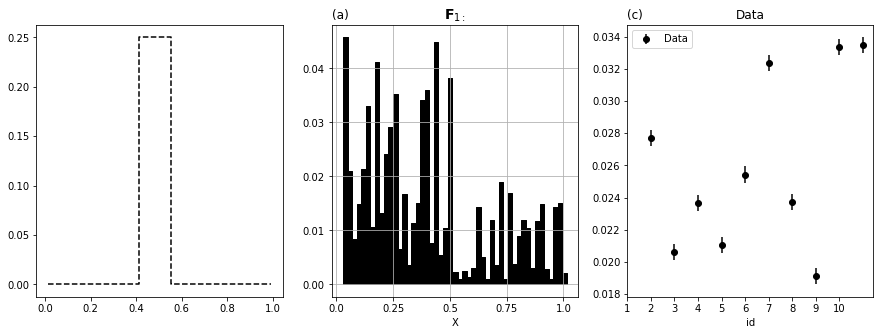

In [7]:
fig = plt.figure(figsize=(15, 5))
axs = plt.subplot(1,3,1)
#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')
axs.step(mesh2.vectorCCx, mtrue2, 'k', lw=1.5, linestyle='--')

ax1 = plt.subplot(1,3,2)
ax1.fill_between(ccx,F2[i, :], step="pre", alpha=1.0, color=np.r_[0,0,0]/(i+2))
#     ax1.step(mesh.vectorCCx, prob.F[i, :], color=np.r_[1,1,1]/(i+2), lw=2)
ax1.set_title('$\mathbf{F}_{1:}$', size=14)
ax1.set_title('(a)', loc='left')
ax1.set_xticks(np.linspace(-1,49,5)/50)
ax1.set_xticklabels(np.linspace(0,1,5))
ax1.set_xlabel("X")
ax1.grid('on')

ax3 = plt.subplot(1,3,3)
ax3.errorbar(np.asarray(range(10))+1,data,yerr=wd,linestyle=' ', color='k', marker='o')
# ax3.plot(survey.dobs,'k--')
ax3.set_title('Data')
ax3.set_title('(c)', loc='left')
ax3.set_xlabel("id")
ax3.set_xticks(range(0,nk))
ax3.set_xticklabels(range(1,nk+1))
ax3.legend(['Data', 'Data+noise'])
plt.show()

In [8]:
# Define a small function that takes a model, p and epsilon values and return the value of the norm

def invSetter(count, p_s, p_x, a_s, a_x, eps_p, eps_q, coolFact, bounds):
       
    dmis = DataMisfit.l2_DataMisfit(survey)
    dmis.W = 1./wd
    
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+2)

#     reg.scales = np.c_[dx,  1./dx]
 
    reg = Regularization.Sparse(mesh2, mapping=idenMap,gradientType='components', scaledIRLS=False)

    reg.mref = np.zeros(mesh2.nC)
#     reg.cell_weights = mesh.vol
#     reg.cell_weights = wr
    reg.norms = np.c_[p_s, p_x]
    reg.eps_p = eps_p
    reg.eps_q = eps_q
    reg.alpha_x = a_x
    reg.alpha_s = a_s
    beta = 5e+3*800.

    print(p_s, p_x, reg.alpha_s, reg.alpha_x)
    opt = Optimization.ProjectedGNCG(
        maxIter=100, lower=bounds[0], upper=bounds[1],
        maxIterLS=20, maxIterCG=100, tolCG=1e-6,
        tolG = -1, eps=-1,
        tolF = -1, tolX= -1
    )

    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=beta)
    update_Jacobi = Directives.UpdatePreconditioner()

    # Set the IRLS directive, penalize the lowest 25 percentile of model values
    # Start with an l2-l2, then switch to lp-norms
    
    saveDict = Directives.SaveOutputDictEveryIteration()
    
    IRLS = Directives.Update_IRLS(maxIRLSiter=100, minGNiter=1,
                                  coolEpsFact=coolFact, f_min_change = 1e-4, beta_tol = 0.1,
                                 chifact_target=1., coolEps_p=True, coolEps_q=True,
                                 floorEps_p = 1e-6, floorEps_q = 1e-6, )

    inv = Inversion.BaseInversion(
        invProb,
        directiveList=[IRLS, update_Jacobi, saveDict]
    )

    # Run inversion
    mrec = inv.run(np.ones(mesh2.nC)*1e-4)
    return mrec, invProb, dmis, saveDict.outDict, reg


p_s = [1]#mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist() + [1]
p_x = [1]#mkvc(np.kron(np.ones((3,1)),np.r_[2,1,0])).tolist() + [1]
alpha_x = np.r_[1]#.tolist()*3 + [1]
alpha_s = np.r_[1]#.tolist()*3 + [1.]
coolFact = 1.125

# p_s = [2,1,0]
# p_x = [2,1,0]
# alpha_x = [1,1,1]
# alpha_s = [1,1,1]
# coolFact = 1.15

eps_p0,eps_q0 = 1e-2, 1e-2
scaledIRLS = False
for jj, (p, q, a_s, a_x) in enumerate(zip(p_s, p_x, alpha_s, alpha_x)):
        
    mm, invProb, dmis, outDict, reg = invSetter(jj, p, q, a_s, a_x, eps_p0, eps_q0, coolFact, [- np.inf,  np.inf])
    print(len(outDict.keys()))
    models += [mm]
    dpred += [invProb.dpred]
    regAll += [reg]
#     iterations += [[iterate]]
    eps_p.append([outDict[ii+1]['eps_p'] for ii in range(invProb.opt.iter)])
    eps_q.append([outDict[ii+1]['eps_q'] for ii in range(invProb.opt.iter)])
    lp.append([outDict[ii+1]['lps'] for ii in range(invProb.opt.iter)])
    lq.append([outDict[ii+1]['lpx'] for ii in range(invProb.opt.iter)])
    phi_s.append([np.abs(outDict[ii+1]['phi_ms']).max() for ii in range(invProb.opt.iter)])
    phi_x.append([np.abs(outDict[ii+1]['phi_msx']).max() for ii in range(invProb.opt.iter)])
    phi_d.append([outDict[ii+1]['phi_d'] for ii in range(invProb.opt.iter)])
    betas.append([outDict[ii+1]['beta'] for ii in range(invProb.opt.iter)])
    reg_eps.append([reg.eps_p, reg.eps_q])
    phi_s_Deriv.append([np.abs(outDict[ii+1]['dphisdm']).max() for ii in range(invProb.opt.iter)])
    phi_x_Deriv.append([np.abs(outDict[ii+1]['dphixdm']).max() for ii in range(invProb.opt.iter)])
    phi_d_Deriv.append([np.abs(dmis.deriv(outDict[ii+1]['m'])).max() for ii in range(invProb.opt.iter)])




SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
1 1 1.0 1.0
Approximated diag(JtJ) with linear operator
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-09-12-10-57.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e+06  1.40e+04  5.00e-09  1.40e+04    1.07e+05      0              
Start CG solve
CG solve time: 0.30849790573120117
   1  2.00e+06  7.10e+02  3.99e-04  1.51e+03    7.09e+03      0              
Start CG solve
CG solve time: 0.2895047664642334
   2  1.00e+06  4.24e+02  4.99e-04  9.22e+02    4.00e+03      0   Skip BFGS  
Start CG solve
CG solve time: 0.312999963760376
   3  5.00e+05  2.44e+02  6.26e-04  5.57e+02    2.28e+03      0   Skip BFGS  
Start CG so

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:915: RuntimeWarning: invalid value encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


   8  1.56e+04  2.02e+00  2.69e-02  4.22e+02    2.39e+03      0   Skip BFGS  
Start CG solve
CG solve time: 0.46923279762268066
Beta search step
   8  1.17e+04  2.02e+00  2.69e-02  3.17e+02    1.74e+03      0              


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


Start CG solve
CG solve time: 0.46249890327453613
Beta search step
   8  8.79e+03  2.02e+00  2.69e-02  2.38e+02    1.26e+03      0   Skip BFGS  

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)



Start CG solve
CG solve time: 0.500502347946167
Beta search step
   8  6.59e+03  2.02e+00  2.69e-02  1.79e+02    8.92e+02      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.6177759170532227
Beta search step
   8  4.94e+03  2.02e+00  2.69e-02  1.35e+02    6.20e+02      0   Skip BFGS  

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)



Start CG solve
CG solve time: 0.5359981060028076
Beta search step
   8  3.71e+03  2.02e+00  2.69e-02  1.02e+02    4.19e+02      0   Skip BFGS  


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


Start CG solve
CG solve time: 0.6045005321502686
Beta search step
   8  2.78e+03  2.02e+00  2.69e-02  7.67e+01    2.72e+02      0   Skip BFGS  
Start CG solve


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)


CG solve time: 0.6929240226745605
Beta search step
   8  3.24e+03  2.02e+00  2.69e-02  8.89e+01    3.43e+02      0   Skip BFGS  

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\array\core.py:3808: RuntimeWarning: divide by zero encountered in true_divide
  result = function(*args, **kwargs)



Start CG solve
CG solve time: 0.6140289306640625
delta phim: 1.480e+01
   9  3.24e+03  5.46e+00  2.30e-02  7.99e+01    1.59e+02      0              
Start CG solve
CG solve time: 0.6574950218200684
delta phim: 3.424e-02
  10  3.24e+03  5.38e+00  2.17e-02  7.55e+01    1.14e+02      0   Skip BFGS  
Start CG solve
CG solve time: 0.7890012264251709
delta phim: 3.064e-02
  11  3.24e+03  5.12e+00  2.11e-02  7.33e+01    8.81e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5545003414154053
delta phim: 1.745e-02
  12  3.24e+03  4.93e+00  2.08e-02  7.21e+01    6.69e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5915312767028809
delta phim: 9.178e-03
  13  3.24e+03  4.80e+00  2.06e-02  7.15e+01    5.16e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5559992790222168
delta phim: 4.621e-03
  14  3.24e+03  4.73e+00  2.06e-02  7.12e+01    4.29e+01      0   Skip BFGS  
Start CG solve
CG solve time: 0.5544319152832031
delta phim: 2.459e-03
  15  3.24e+03  4.70e+00  2.05e-02

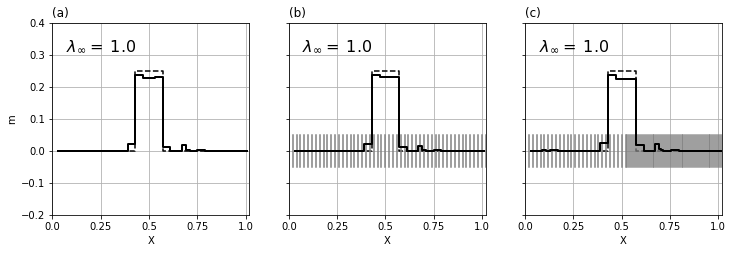

In [18]:
fig = plt.figure(figsize=(12, 12))
label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

for ii, mrec in enumerate(models):
    
# axes[0].plot(survey.dobs)
# axes[0].plot(invProb.dpred)

    axs = plt.subplot(3,3,ii+1)
#     axs.step(mesh.vectorCCx, invProb.l2model, 'r-')

    if ii < 2:
        axs.step(mesh.vectorCCx, mtrue, 'k', lw=1.5, linestyle='--')
    else:
        axs.step(mesh2.vectorCCx, mtrue2, 'k', lw=1.5, linestyle='--')
    
    if ii > 0:
        # Plot discreatization
        if ii==1:
            for hx in mesh.vectorNx.tolist():
                axs.plot([hx, hx], [-.05, 0.05], 'gray')            
        else:
            for hx in mesh2.vectorNx.tolist():
                axs.plot([hx, hx], [-.05, 0.05], 'gray')
#     axs.fill_between(xx, 0, true)
#     axes[1].step(mesh.vectorCCx, invProb.l2model, 'r-')

    # axes[1].legend(('True Model', 'Recovered Model'))
    axs.set_ylim(-.2, 0.4)
    axs.set_xlim(0,mesh.vectorNx[-1])
    axs.set_xlabel("X")
    axs.set_xticks(np.linspace(-1,49,5)/50)
    axs.set_xticklabels(np.linspace(0,1,5))
    axs.set_ylabel("m")
#     if ii<6:
#         axs.set_xticklabels([])
#         axs.set_xlabel("")
    if ii%3 != 0:
        axs.set_yticklabels([])
        axs.set_ylabel("")
        
    
    axs.set_title(label[ii], loc='left')
#     axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    
#     if ii == 0:
    if ii >1 :
#         axs.fill_between(mesh.vectorCCx,mLP.x, step="pre", alpha=1.)
        axs.step(mesh2.vectorCCx, mrec, 'k-', lw=2)
        
#         axs.step(mesh.vectorCCx, mLP.x, lw=2)
#         axs.legend(['True', 'IRLS', 'Simplex'])
    else:
        axs.step(mesh.vectorCCx, mrec, 'k-', lw=2)
#         axs.fill_between(mesh.vectorCCx,mLP.x, step="pre", alpha=1.)
# #         axs.step(mesh.vectorCCx, mLP.x, lw=2)
#         axs.legend(['True','IRLS', 'BP-Interior'])
#     else:
#         axs.step(mesh.vectorCCx, mrec, 'k-', lw=3)
    axs.grid('on')

#     axs.set_title('$\phi_m^' + str(int(np.round(p_x[ii]))) +'\:=\:'+ '\\alpha_s\:\phi_s^' + str(int(np.round(p_s[ii]))) +'$' + ' + $\\alpha_x\:\phi_x^' + str(int(p_x[ii])) +'$', size=15) 
    axs.text(0.05,0.31,'$\lambda_\infty=\;$'+str(np.round(phi_s_Deriv[ii][-1]/phi_x_Deriv[ii][-1]*100)/100), size=16)

plt.show()
fig.savefig('Problem1D_Results_l1_NormalizingTest.png',bbox_inches='tight')

In [73]:
for ii, beta in enumerate(betas):
    print("%.2f & %.2f & %.1f & %.1f & %.2f & %.2f & %.2f & %.2f" % (
        phi_d[ii][-1].compute(),
        beta[-1],
        regAll[ii].alpha_s,
        regAll[ii].alpha_x**0,
        beta[-1]*regAll[ii].alpha_s * phi_s[ii][-1], 
        beta[-1]*regAll[ii].alpha_x * phi_x[ii][-1]))





5.16 & 493.90 & 50.0 & 1.0 & 1.00 & 1.00 & 125.60 & 0.00
5.11 & 55773.36 & 1.0 & 1.0 & 1.00 & 1.00 & 184.61 & 0.00
5.24 & 15375.30 & 1.0 & 1.0 & 1.00 & 1.00 & 76.56 & 0.00
